# LSTM Encoder-Decoder Model Approach for Battery Capacity Degradation Model

**References:**

[1] `K. Park, Y. Choi, W. J. Choi, H.-Y. Ryu, and H. Kim, “Lstm-based battery remaining useful
life prediction with multi-channel charging profiles”, IEEE Access, vol. 8, pp. 20 786–20 798, 2020. doi: 10.1109/ACCESS.2020.2968939.`

[2] `I. Gridin, Time series forecasting using deep learning combining pytorch, RNN, TCN, and deep neural network models to provide production-ready prediction solutions, English. BPB
Publications, 2022`

[3] `https://github.com/lkulowski/LSTM_encoder_decoder`

## Import google drive

In [ ]:
# import google drive
from google.colab import drive

# mount drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## Import Python Modules

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from torch import optim
from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

## Setup device agnostic code

In [ ]:
# Setting up device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Moving files to Working Directory

In [ ]:
# zipfiles complete path
b1 = '/content/drive/MyDrive/CS2/Cycled at constant current of 1C/CS2_35.zip'
b2 = '/content/drive/MyDrive/CS2/Cycled at constant current of 1C/CS2_36.zip'
b3 = '/content/drive/MyDrive/CS2/Cycled at constant current of 1C/CS2_37.zip'
b4 = '/content/drive/MyDrive/CS2/Cycled at constant current of 1C/CS2_38.zip'

battery_list = [b1, b2, b3, b4]
Battery_names = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
# Setup path to date folder
data_path = Path("data/")
calce_datapath = data_path / "calce"

# If the dataset folder doesn't exist download it and prepare it...
if calce_datapath.is_dir():
    print(f"{calce_datapath} directory exists.")
else:
    print(f"Did not find {calce_datapath} directory, creating one...")
    calce_datapath.mkdir(parents=True, exist_ok=True)

    # move zip file to data_path
    print("Moving zip files to calce-battery directory...")
    for bat in battery_list:
        filename = bat.split("/")[-1].split(".")[0]
        filepath = bat.split("/")[-1]
        print(f"Moving {filename}.zip ...")
        shutil.copy(bat, data_path)
        with zipfile.ZipFile(data_path / filepath, "r") as zip_ref:
            print(f"Unzipping {filepath} ...")
            zip_ref.extractall(calce_datapath)

Did not find data/calce directory, creating one...
Moving zip files to calce-battery directory...
Moving CS2_35.zip ...
Unzipping CS2_35.zip ...
Moving CS2_36.zip ...
Unzipping CS2_36.zip ...
Moving CS2_37.zip ...
Unzipping CS2_37.zip ...
Moving CS2_38.zip ...
Unzipping CS2_38.zip ...


## Convertin `.csv` files to pandas dataframe

In [ ]:
# drop outliers to get indexes
def drop_outlier(array, count, bins):
    index = []
    out_range = np.arange(1, count, bins)
    for i in out_range[:-1]:
        array_lim = array[i : i + bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

### Process `.csv` files

In [ ]:
import pandas as pd
import glob

Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = '/content/data/calce/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:    
        file_path = p.split("/")[-1].split(".")[0].split("_")[-3:]
        date_str = str(file_path[0] + "/" + file_path[1] + "/" + file_path[2]) 
        date = datetime.strptime(date_str, '%m/%d/%y')
        dates.append(date)
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result

Load Dataset CS2_35 ...
Load /content/data/calce/CS2_35/CS2_35_8_17_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_8_18_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_8_19_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_8_30_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_9_7_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_9_8_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_9_21_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_9_30_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_10_15_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_10_22_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_10_29_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_11_01_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_11_08_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_11_23_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_11_24_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_12_06_10.xlsx ...
Load /content/data/calce/CS2_35/CS2_35_12_13_10.xlsx ...
Load /content/dat

### Visualize Battery Capacity Degradation

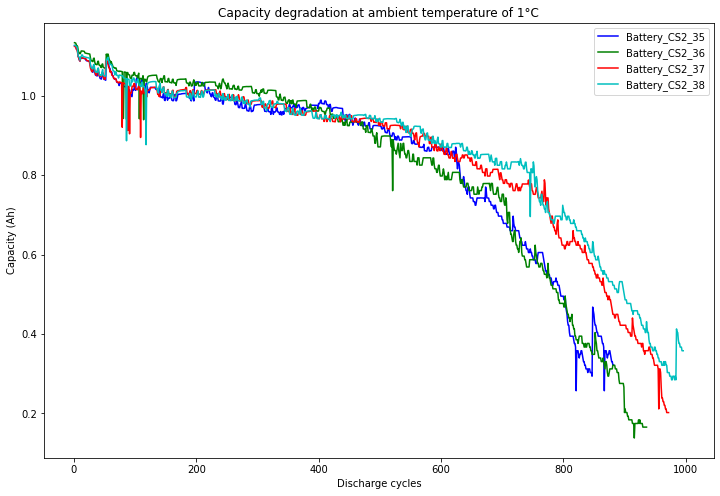

In [ ]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12,8))
color_list = ['b', 'g', 'r', 'c']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label = 'Battery_'+name)
ax.set(xlabel = 'Discharge cycles', ylabel = 'Capacity (Ah)', title = 'Capacity degradation at ambient temperature of 1°C')
plt.legend()

## Further data processing to transform the datasets to train and test sets

Sliding window function

In [ ]:
# SLIDING WINDOW
def sliding_window(ts, ts_history_len, ts_target_len, stride):
    X = []
    Y = []
    num_samples = (len(ts) - ts_history_len - ts_target_len) // stride + 1 
    #for i in range(ts_history_len + 1, len(ts) - ts_target_len):
    for i in range(num_samples):
        #X.append(ts[i - (ts_history_len + 1):i - 1])
        init_x = stride * i
        fin_x = init_x + ts_history_len
        X.append(ts[init_x:fin_x])

        #Y.append(ts[i - 1 :i - 1 + ts_target_len])
        init_y = stride * i + ts_history_len
        fin_y = init_y + ts_target_len
        Y.append(ts[init_y:fin_y])

    return X,Y 

In [ ]:
# CS2_35
df_cap35 = Battery['CS2_35']['capacity']
# CS2_36
df_cap36 = Battery['CS2_36']['capacity']
# CS2_37
df_cap37 = Battery['CS2_37']['capacity']
# CS2_38
df_cap38 = Battery['CS2_38']['capacity']

len(df_cap35), len(df_cap36), len(df_cap37), len(df_cap38)

(882, 936, 972, 996)

### transform to numpy arrays and normalize using `MinMaxScaler()`

In [ ]:
x_cap35 = np.array(list(df_cap35)).reshape(-1, 1)
x_cap36 = np.array(list(df_cap36)).reshape(-1, 1)
x_cap37 = np.array(list(df_cap37)).reshape(-1, 1)
x_cap38 = np.array(list(df_cap38)).reshape(-1, 1)

x_cap35.shape, x_cap36.shape, x_cap37.shape, x_cap38.shape

((882, 1), (936, 1), (972, 1), (996, 1))

In [ ]:
# Observe the max and min values
max_35 = max(x_cap35)
min_35 = min(x_cap35)

max_36 = max(x_cap36)
min_36 = min(x_cap36)

max_37 = max(x_cap37)
min_37 = min(x_cap37)

max_38 = max(x_cap38)
min_38 = min(x_cap38)

max_35, min_35, max_36, min_36, max_37, min_37, max_38, min_38

(array([1.12638451]),
 array([0.25667719]),
 array([1.13380661]),
 array([0.13754796]),
 array([1.12425147]),
 array([0.20170847]),
 array([1.12696392]),
 array([0.28418502]))

In [ ]:
# CS2_36 had the max and min values so will use that as the scaler
scaler_0 = MinMaxScaler(feature_range=(0,1))
scaler_0 = scaler_0.fit(x_cap36)
x_cap35_norm = scaler_0.transform(x_cap35)
x_cap36_norm = scaler_0.transform(x_cap36)
x_cap37_norm = scaler_0.transform(x_cap37)
x_cap38_norm = scaler_0.transform(x_cap38)

In [ ]:
from pickle import dump
dump(scaler_0, open('scaler.pkl', 'wb'))

In [ ]:
# transform it back to type list
x_cap35_norm = x_cap35_norm.tolist()
x_cap36_norm = x_cap36_norm.tolist()
x_cap37_norm = x_cap37_norm.tolist()
x_cap38_norm = x_cap38_norm.tolist()

In [ ]:
# input history
train_period = 80
# prediction length
prediction_period = 80
# stride (make it similar to prediction_period)
stride = 1

# call sliding window function
X_35, Y_35 = sliding_window(x_cap35_norm, train_period, prediction_period, stride)
X_36, Y_36 = sliding_window(x_cap36_norm, train_period, prediction_period, stride)
X_37, Y_37 = sliding_window(x_cap37_norm, train_period, prediction_period, stride)
X_38, Y_38 = sliding_window(x_cap38_norm, train_period, prediction_period, stride)

X_35, Y_35 = np.array(X_35), np.array(Y_35)
X_36, Y_36 = np.array(X_36), np.array(Y_36)
X_37, Y_37 = np.array(X_37), np.array(Y_37)
X_38, Y_38 = np.array(X_38), np.array(Y_38)

X_35, Y_35 = np.squeeze(X_35), np.squeeze(Y_35)
X_36, Y_36 = np.squeeze(X_36), np.squeeze(Y_36)
X_37, Y_37 = np.squeeze(X_37), np.squeeze(Y_37)
X_38, Y_38 = np.squeeze(X_38), np.squeeze(Y_38)

X_35.shape, Y_35.shape, X_36.shape, Y_36.shape, X_37.shape, Y_37.shape, X_38.shape, Y_38.shape

((723, 80),
 (723, 80),
 (777, 80),
 (777, 80),
 (813, 80),
 (813, 80),
 (837, 80),
 (837, 80))

In [ ]:
# put array pairs into a dictionary for easier access when training
train_battery = {}
CS2_35 = {}
CS2_35['X'] = X_35
CS2_35['Y'] = Y_35 
train_battery['CS2_35'] = CS2_35
CS2_36 = {}
CS2_36['X'] = X_36
CS2_36['Y'] = Y_36 
train_battery['CS2_36'] = CS2_36
CS2_37 = {}
CS2_37['X'] = X_37
CS2_37['Y'] = Y_37 
train_battery['CS2_37'] = CS2_37

In [ ]:
# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()

## LSTM Encoder-Decoder Model

The model is adapted from [2]

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ratio during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

## Performance Metrics

In [ ]:
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from collections import Counter
import linecache
import os
import tracemalloc

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

## grid search

In [ ]:
# grid search for best hyperparameters
train_list = ['CS2_35', 'CS2_36', 'CS2_37']

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# lstm hidden size 
hidden_size = [32, 64, 128, 256]
# learning rate 
learn_rate = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
# teacher forcing ratio
tfratio = [0.05, 0.1, 0.3, 0.5]
# training epochs
epochs = 500
# input history
train_period = 80
# prediction length
prediction_period = 80
for hd_size in hidden_size:
    for lr in learn_rate:
        for tfr in tfratio:
            print("================== Training Mode ===================")
            print(f'hidden_size: {hd_size} | learning rate: {lr} | teacher-forcing ratio: {tfr}')
            model_optim = EncoderDecoder(hidden_size = hd_size)
            model_optim.to(device)

            model_optim.train()
            losses_optim = model_optim.train_model(train_battery=train_battery,
                                                   train_list=train_list,
                                                   epochs=epochs,
                                                   target_len=prediction_period,
                                                   method='mixed_teacher_forcing',
                                                   tfr = tfr,
                                                   lr = lr)
            print("================== Inference Mode ===================")
            # inference mode on CS2_38
            df_cap38 = Battery['CS2_38']['capacity']
            x_cap38 = np.array(list(df_cap38)).reshape(-1, 1)
            x_cap38_norm = scaler_0.transform(x_cap38)
            x_cap38_norm = x_cap38_norm.tolist()
            train_split = 0.70
            x_input = x_cap38_norm[0:int(len(x_cap38_norm)*train_split)]
            x_target = x_cap38_norm[int(len(x_cap38_norm)*train_split):]
            X = inference_window(x_input, train_period)
            X = np.array(X)
            X = np.squeeze(X)
            x_in = to_tensor(X)
            x_in = x_in.to(device)
            output = []

            model_optim.eval()
            max_length = len(x_cap38_norm) - (len(x_cap38_norm) % train_period) + train_period

            while len(x_input) <= max_length:
                predicted = model_optim.predict(x_in, prediction_period)
                pred_seq = predicted[:, -1, :].view(-1).tolist()   
                for i in range(len(pred_seq)):
                    x_input.append([pred_seq[i]])
                    output.append([pred_seq[i]])
                X = inference_window(x_input, train_period)
                X = np.array(X)
                X = np.squeeze(X)
                x_in = to_tensor(X)
                x_in = x_in.to(device)
        
            x_cap38= x_cap38.tolist()
            train_split = 0.70
            x_input_test = x_cap38[0:int(len(x_cap38)*train_split)]
            x_target_test = x_cap38[int(len(x_cap38)*train_split):]
            output = scaler_0.inverse_transform(np.array(output).reshape(-1,1))
            output = output.tolist()
            acc = accuracy(torch.Tensor(x_target_test), torch.Tensor(output[:len(x_target_test)])) * 100
            mae = mean_absolute_error(output[:len(x_target_test)], x_target_test)
            mse = sqrt(mean_squared_error(output[:len(x_target_test)], x_target_test))
            print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
        

================== Training Mode ===================
hidden_size: 32 | learning rate: 0.0001 | teacher-forcing ratio: 0.05
Battery: CS2_35 |Epoch 0/500: 0.2148
Battery: CS2_36 |Epoch 0/500: 0.2033
Battery: CS2_37 |Epoch 0/500: 0.2107
Battery: CS2_35 |Epoch 100/500: 0.0165
Battery: CS2_36 |Epoch 100/500: 0.026
Battery: CS2_37 |Epoch 100/500: 0.0152
Battery: CS2_35 |Epoch 200/500: 0.0126
Battery: CS2_36 |Epoch 200/500: 0.0196
Battery: CS2_37 |Epoch 200/500: 0.0112
Battery: CS2_35 |Epoch 300/500: 0.002
Battery: CS2_36 |Epoch 300/500: 0.0041
Battery: CS2_37 |Epoch 300/500: 0.0018
Battery: CS2_35 |Epoch 400/500: 0.0013
Battery: CS2_36 |Epoch 400/500: 0.0029
Battery: CS2_37 |Epoch 400/500: 0.0013
Battery: CS2_35 |Epoch 500/500: 0.0013
Battery: CS2_36 |Epoch 500/500: 0.0027
Battery: CS2_37 |Epoch 500/500: 0.0012
================== Inference Mode ===================
MAE: 0.0677 | RMSE: 0.0856 | Accuracy: 84.75
================== Training Mode ===================
hidden_size: 32 | learning rate

Based on the grid search implementation, the hyperparameters that achieved the best results were `hidden_size = 32` & `learning_rate = 0.005`

Battery: CS2_38 | Dataset Length: 996 | Input Length: 697 | Target Length: 299
trained on device: cuda
hidden size: 32 | learning rate: 0.01 | teacher-forcing ratio: 0.1 | test split: 0.7
MAE: 0.0216 | RMSE: 0.0297 | Accuracy: 95.87


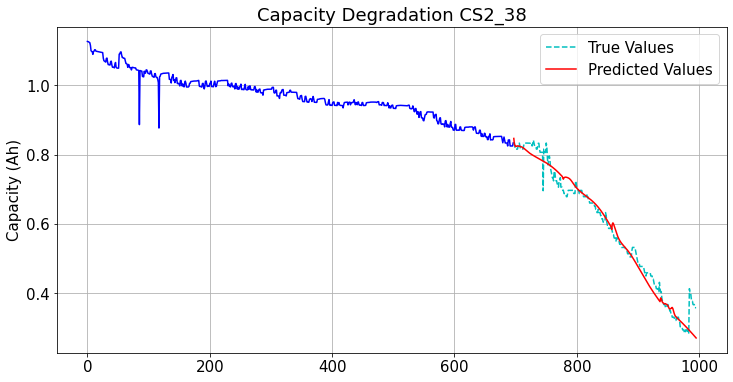

In [ ]:
# inference mode on CS2_38
battery_name = 'CS2_38'
scaler = scaler_0

df = Battery[battery_name]['capacity']
x_cap = np.array(list(df)).reshape(-1, 1)
x_cap_norm = scaler.transform(x_cap)
x_cap_norm = x_cap_norm.tolist()
train_split = 0.70
x_input = x_cap_norm[0:int(len(x_cap_norm)*train_split)]
x_target = x_cap_norm[int(len(x_cap_norm)*train_split):]
print(f'Battery: {battery_name} | Dataset Length: {len(x_cap_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 
print(f"trained on device: {device}")
# input history
train_period = 80
# prediction length
prediction_period = 80

X = inference_window(x_input, train_period)
X = np.array(X)
X = np.squeeze(X)
x_in = to_tensor(X)
x_in = x_in.to(device)
output = []

model_0.eval()
max_length = len(x_cap_norm) - (len(x_cap_norm) % train_period) + train_period
#max_length = 5000
while len(x_input) <= max_length:
    predicted = model_0.predict(x_in, prediction_period)
    pred_seq = predicted[:, -1, :].view(-1).tolist()   
    for i in range(len(pred_seq)):
        x_input.append([pred_seq[i]])
        output.append([pred_seq[i]])
    X = inference_window(x_input, train_period)
    X = np.array(X)
    X = np.squeeze(X)
    x_in = to_tensor(X)
    x_in = x_in.to(device)    


x_cap = x_cap.tolist()
x_input = x_cap[0:int(len(x_cap)*train_split)]
x_target = x_cap[int(len(x_cap)*train_split):]
output = scaler.inverse_transform(np.array(output).reshape(-1,1))
output = output.tolist()
acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
mae = mean_absolute_error(output[:len(x_target)], x_target)
mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))
#tfr = .1
#lr = .005
print(f"hidden size: {hidden_size} | learning rate: {lr} | teacher-forcing ratio: {tfr} | test split: {train_split}")
print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")

import matplotlib as mpl
x = range(0, len(x_cap_norm))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(12,6))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

## Train set CS2_35, CS2_36 & CS2_37 | Test set CS2_38

In [ ]:
train_list = ['CS2_35', 'CS2_36', 'CS2_37']

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# lstm hidden size 
hidden_size = 32
# learning rate
lr = 
# teacher-forcing ratio
tfr
# training epochs
epochs = 500
# input history
train_period = 80
# prediction length
prediction_period = 80

model_0 = EncoderDecoder(hidden_size = hidden_size)
#model_0.to(device)

model_0.train()
losses_0 = model_0.train_model(train_battery=train_battery,
                               train_list=train_list,
                               epochs=epochs,
                               target_len=prediction_period,
                               method='mixed_teacher_forcing',
                               tfr = tfr,
                               lr = lr)

Battery: CS2_35 |Epoch 0/500: 0.3224
Battery: CS2_36 |Epoch 0/500: 0.2659
Battery: CS2_37 |Epoch 0/500: 0.234
Battery: CS2_35 |Epoch 100/500: 0.0159
Battery: CS2_36 |Epoch 100/500: 0.025
Battery: CS2_37 |Epoch 100/500: 0.0152
Battery: CS2_35 |Epoch 200/500: 0.0005
Battery: CS2_36 |Epoch 200/500: 0.0005
Battery: CS2_37 |Epoch 200/500: 0.0003
Battery: CS2_35 |Epoch 300/500: 0.0004
Battery: CS2_36 |Epoch 300/500: 0.0003
Battery: CS2_37 |Epoch 300/500: 0.0003
Battery: CS2_35 |Epoch 400/500: 0.0004
Battery: CS2_36 |Epoch 400/500: 0.0003
Battery: CS2_37 |Epoch 400/500: 0.0002
Battery: CS2_35 |Epoch 500/500: 0.0004
Battery: CS2_36 |Epoch 500/500: 0.0003
Battery: CS2_37 |Epoch 500/500: 0.0002


In [ ]:
train_list = ['CS2_35', 'CS2_36', 'CS2_37']

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# lstm hidden size 
hidden_size = 32
# learning rate
lr = 0.01
# teacher-forcing ratio
tfr = 0.1
# training epochs
epochs = 500
# input history
train_period = 80
# prediction length
prediction_period = 80

model_0 = EncoderDecoder(hidden_size = hidden_size)
model_0.to(device)

model_0.train()
losses_0 = model_0.train_model(train_battery=train_battery,
                               train_list=train_list,
                               epochs=epochs,
                               target_len=prediction_period,
                               method='mixed_teacher_forcing',
                               tfr = tfr,
                               lr = lr)

Battery: CS2_35 |Epoch 0/500: 0.2141
Battery: CS2_36 |Epoch 0/500: 0.1507
Battery: CS2_37 |Epoch 0/500: 0.1121
Battery: CS2_35 |Epoch 100/500: 0.0161
Battery: CS2_36 |Epoch 100/500: 0.0255
Battery: CS2_37 |Epoch 100/500: 0.0152
Battery: CS2_35 |Epoch 200/500: 0.0003
Battery: CS2_36 |Epoch 200/500: 0.0005
Battery: CS2_37 |Epoch 200/500: 0.0003
Battery: CS2_35 |Epoch 300/500: 0.0004
Battery: CS2_36 |Epoch 300/500: 0.0003
Battery: CS2_37 |Epoch 300/500: 0.0002
Battery: CS2_35 |Epoch 400/500: 0.0004
Battery: CS2_36 |Epoch 400/500: 0.0002
Battery: CS2_37 |Epoch 400/500: 0.0001
Battery: CS2_35 |Epoch 500/500: 0.0004
Battery: CS2_36 |Epoch 500/500: 0.0003
Battery: CS2_37 |Epoch 500/500: 0.0002


### Loss plot

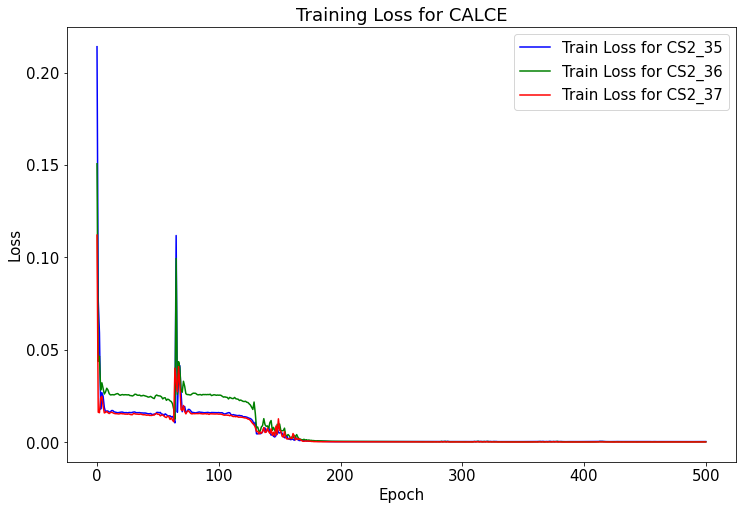

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8))
color_list = ['b', 'g', 'r']

for name, color in zip(train_list, color_list):
    df_result = losses_0[name]
    x = np.arange(0, len(df_result))
    ax.plot(x, df_result, color, label = 'Train Loss for '+name)
ax.set(xlabel = 'Epoch', ylabel = 'Loss', title = 'Training Loss for CALCE')
plt.legend()

### visualization

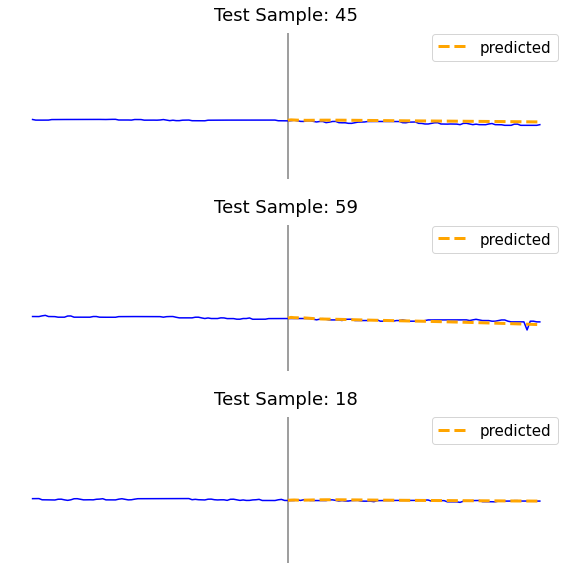

In [ ]:
x_test = to_tensor(X_38)
y_test = to_tensor(Y_38)
test_ds_len = len(X_38) - 1

model_0.eval()
predicted = model_0.predict(x_test, prediction_period)

fig, ax = plt.subplots(nrows = 3, ncols = 1)
fig.set_size_inches(10, 10)
for col in ax:
    r = random.randint(0, test_ds_len)
    in_seq = x_test[:, r, :].view(-1).tolist()
    target_seq = y_test[:, r, :].view(-1).tolist()
    pred_seq = predicted[:, r, :].view(-1).tolist()
    x_axis = range(len(in_seq) + len(target_seq))
    col.set_title(f'Test Sample: {r}')
    col.axis('off')
    col.plot(x_axis[:], in_seq + target_seq, color = 'blue')
    col.plot(x_axis[len(in_seq):],
             pred_seq,
             label = 'predicted',
             color = 'orange',
             linestyle = 'dashed',
             linewidth = 3)
    col.vlines(len(in_seq), 0, 2, color = 'grey')
    col.legend(loc = "upper right")
plt.show()

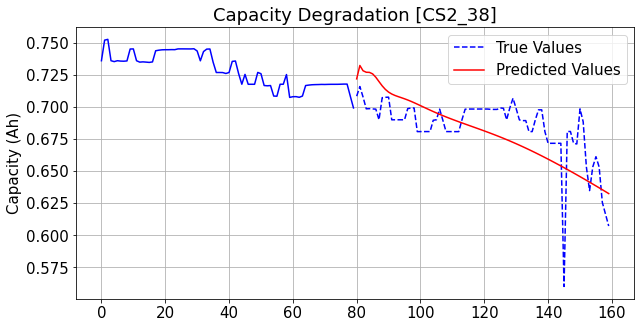

In [ ]:
import matplotlib as mpl
x = np.arange(0, len(x_test) + len(y_test))
font = {'size'   : 15}
r = 60
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation [CS2_38]')
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(y_test)],
         x_test[:, r, :].view(-1).tolist(),
         "b-")
plt.plot(x[-len(y_test):],
         y_test[:, r, :].view(-1).tolist(),
         "b--",
         label='True Values')
plt.plot(x[-len(y_test):],
         predicted[:, r, :].view(-1).tolist(),
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

In [ ]:
def inference_window(x_input, train_period):
    rem = len(x_input) % train_period
    index = abs(rem - len(x_input))
    num_samples = index // train_period
    x = []
    init_x = -index
    for i in range(num_samples):
        '''
        x.append(x_input[-index-a: a])
        a = a + 100
        index =
        '''
        fin_x = init_x + train_period
        if fin_x == 0:
            x.append(x_input[init_x:])
        else:
            x.append(x_input[init_x:fin_x])
        init_x = fin_x
                      
    return x

### inference mode

In [ ]:
# inference mode on CS2_38
df_cap38 = Battery['CS2_38']['capacity']
x_cap38 = np.array(list(df_cap38)).reshape(-1, 1)
x_cap38_norm = scaler_0.transform(x_cap38)
x_cap38_norm = x_cap38_norm.tolist()
train_split = 0.60
x_input = x_cap38_norm[0:int(len(x_cap38_norm)*train_split)]
x_target = x_cap38_norm[int(len(x_cap38_norm)*train_split):]
print(f'Dataset Length: {len(x_cap38_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 

# input history
train_period = 80
# prediction length
prediction_period = 80

X = inference_window(x_input, train_period)
X = np.array(X)
X = np.squeeze(X)
x_in = to_tensor(X)
#x_in = x_in.to(device)
output = []

model_0.eval()
max_length = len(x_cap38_norm) - (len(x_cap38_norm) % train_period) + train_period
#max_length = 5000
while len(x_input) <= max_length:
    predicted = model_0.predict(x_in, prediction_period)
    pred_seq = predicted[:, -1, :].view(-1).tolist()   
    for i in range(len(pred_seq)):
        x_input.append([pred_seq[i]])
        output.append([pred_seq[i]])
    X = inference_window(x_input, train_period)
    X = np.array(X)
    X = np.squeeze(X)
    x_in = to_tensor(X)
    #x_in = x_in.to(device)    

Dataset Length: 996 | Input Length: 597 | Target Length: 399


In [ ]:
# inference mode on CS2_38
df_cap38 = Battery['CS2_38']['capacity']
x_cap38 = np.array(list(df_cap38)).reshape(-1, 1)
x_cap38_norm = scaler_0.transform(x_cap38)
x_cap38_norm = x_cap38_norm.tolist()
train_split = 0.70
x_input = x_cap38_norm[0:int(len(x_cap38_norm)*train_split)]
x_target = x_cap38_norm[int(len(x_cap38_norm)*train_split):]
print(f'Dataset Length: {len(x_cap38_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 

# input history
train_period = 80
# prediction length
prediction_period = 80

X = inference_window(x_input, train_period)
X = np.array(X)
X = np.squeeze(X)
x_in = to_tensor(X)
x_in = x_in.to(device)
output = []

model_0.eval()
max_length = len(x_cap38_norm) - (len(x_cap38_norm) % train_period) + train_period
#max_length = 5000
while len(x_input) <= max_length:
    predicted = model_0.predict(x_in, prediction_period)
    pred_seq = predicted[:, -1, :].view(-1).tolist()   
    for i in range(len(pred_seq)):
        x_input.append([pred_seq[i]])
        output.append([pred_seq[i]])
    X = inference_window(x_input, train_period)
    X = np.array(X)
    X = np.squeeze(X)
    x_in = to_tensor(X)
    x_in = x_in.to(device)    

Dataset Length: 996 | Input Length: 697 | Target Length: 299


In [ ]:
output[:len(x_target)], x_target

MAE: 0.0214 | RMSE: 0.0281 | Accuracy: 95.71


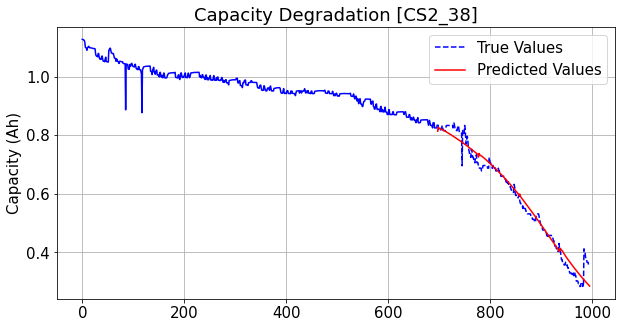

In [ ]:
import numpy as np

df_cap38 = Battery['CS2_38']['capacity']
x_cap38 = np.array(list(df_cap38)).reshape(-1, 1)
#x_cap38_norm = scaler.transform(x_cap38)
x_cap38= x_cap38.tolist()
train_split = 0.70
x_input = x_cap38[0:int(len(x_cap38)*train_split)]
x_target = x_cap38[int(len(x_cap38)*train_split):]
output = scaler_0.inverse_transform(np.array(output).reshape(-1,1))
output = output.tolist()
acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
mae = mean_absolute_error(output[:len(x_target)], x_target)
mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))
print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")

import matplotlib as mpl
x = range(0, len(x_cap38_norm))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation [CS2_38]')
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "b--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

### BETTER INFERENCE CODE

## Saving the Model

In [ ]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "LSTMCALCE_353637.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/LSTMCALCE_353637.pth


In [ ]:
# saving scaler
import joblib
scaler_filename = 'SCALERCALCE_353637.gz'
joblib.dump(scaler_0, scaler_filename)

# to load scaler
# my_scaler = joblib.load(scaler_filename)

['SCALERCALCE_353637.gz']

## Train set CS2_36, CS2_37, CS2_38 | Test set CS2_35

In [ ]:
x_cap36 = np.array(list(df_cap36)).reshape(-1, 1)
x_cap37 = np.array(list(df_cap37)).reshape(-1, 1)
x_cap38 = np.array(list(df_cap38)).reshape(-1, 1)

x_cap36.shape, x_cap37.shape, x_cap38.shape

((936, 1), (972, 1), (996, 1))

In [ ]:
# Observe the max and min values
max_36 = max(x_cap36)
min_36 = min(x_cap36)

max_37 = max(x_cap37)
min_37 = min(x_cap37)

max_38 = max(x_cap38)
min_38 = min(x_cap38)

max_35, min_35, max_36, min_36, max_37, min_37, max_38, min_38

(array([1.12638451]),
 array([0.25667719]),
 array([1.13380661]),
 array([0.13754796]),
 array([1.12425147]),
 array([0.20170847]),
 array([1.12696392]),
 array([0.28418502]))

CS2_36 had the max and min value

In [ ]:
# CS2_36 had the max and min values so will use that as the scaler
scaler_0 = MinMaxScaler(feature_range=(0,1))
scaler_0 = scaler_0.fit(x_cap36)
x_cap36_norm = scaler_0.transform(x_cap36)
x_cap37_norm = scaler_0.transform(x_cap37)
x_cap38_norm = scaler_0.transform(x_cap38)

In [ ]:
# transform it back to type list
x_cap36_norm = x_cap36_norm.tolist()
x_cap37_norm = x_cap37_norm.tolist()
x_cap38_norm = x_cap38_norm.tolist()

In [ ]:
# input history
train_period = 80
# prediction length
prediction_period = 80
# stride (make it similar to prediction_period)
stride = 1

# call sliding window function
X_36, Y_36 = sliding_window(x_cap36_norm, train_period, prediction_period, stride)
X_37, Y_37 = sliding_window(x_cap37_norm, train_period, prediction_period, stride)
X_38, Y_38 = sliding_window(x_cap38_norm, train_period, prediction_period, stride)

X_36, Y_36 = np.array(X_36), np.array(Y_36)
X_37, Y_37 = np.array(X_37), np.array(Y_37)
X_38, Y_38 = np.array(X_38), np.array(Y_38)

X_36, Y_36 = np.squeeze(X_36), np.squeeze(Y_36)
X_37, Y_37 = np.squeeze(X_37), np.squeeze(Y_37)
X_38, Y_38 = np.squeeze(X_38), np.squeeze(Y_38)

X_36.shape, Y_36.shape, X_37.shape, Y_37.shape, X_38.shape, Y_38.shape

((777, 80), (777, 80), (813, 80), (813, 80), (837, 80), (837, 80))

In [ ]:
# put array pairs into a dictionary for easier access when training
train_battery_1 = {}
CS2_36 = {}
CS2_36['X'] = X_36
CS2_36['Y'] = Y_36 
train_battery_1['CS2_36'] = CS2_36
CS2_37 = {}
CS2_37['X'] = X_37
CS2_37['Y'] = Y_37 
train_battery_1['CS2_37'] = CS2_37
CS2_38 = {}
CS2_38['X'] = X_38
CS2_38['Y'] = Y_38 
train_battery_1['CS2_38'] = CS2_38

In [ ]:
train_list_1 = ['CS2_37', 'CS2_38', 'CS2_36']

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# lstm hidden size 
hidden_size = 32
# learning rate
lr = 0.01
# teacher-forcing ratio
tfr = 0.1
# training epochs
epochs = 500
# input history
train_period = 80
# prediction length
prediction_period = 80

model_1 = EncoderDecoder(hidden_size = hidden_size)
model_1.to(device)

model_1.train()
losses_1 = model_1.train_model(train_battery=train_battery_1,
                               train_list=train_list_1,
                               epochs=epochs,
                               target_len=prediction_period,
                               method='mixed_teacher_forcing',
                               tfr = tfr,
                               lr = lr)

Battery: CS2_37 |Epoch 0/500: 0.21
Battery: CS2_38 |Epoch 0/500: 0.1571
Battery: CS2_36 |Epoch 0/500: 0.11
Battery: CS2_37 |Epoch 100/500: 0.0062
Battery: CS2_38 |Epoch 100/500: 0.0048
Battery: CS2_36 |Epoch 100/500: 0.0106
Battery: CS2_37 |Epoch 200/500: 0.0003
Battery: CS2_38 |Epoch 200/500: 0.0003
Battery: CS2_36 |Epoch 200/500: 0.0006
Battery: CS2_37 |Epoch 300/500: 0.0002
Battery: CS2_38 |Epoch 300/500: 0.0002
Battery: CS2_36 |Epoch 300/500: 0.0004
Battery: CS2_37 |Epoch 400/500: 0.0004
Battery: CS2_38 |Epoch 400/500: 0.0003
Battery: CS2_36 |Epoch 400/500: 0.0006
Battery: CS2_37 |Epoch 500/500: 0.0005
Battery: CS2_38 |Epoch 500/500: 0.0003
Battery: CS2_36 |Epoch 500/500: 0.0006


In [ ]:
train_list_1 = ['CS2_37', 'CS2_38', 'CS2_36']

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# lstm hidden size 
hidden_size = 32
# training epochs
epochs = 500
# input history
train_period = 80
# prediction length
prediction_period = 80

model_1 = EncoderDecoder(hidden_size = hidden_size)

model_1.train()
losses_1 = model_1.train_model(train_battery=train_battery_1,
                             train_list=train_list_1,
                             epochs=epochs,
                             target_len=prediction_period,
                             method='mixed_teacher_forcing',
                             tfr = .05,
                             lr = .005)

Battery: CS2_37 |Epoch 0/500: 0.3175
Battery: CS2_38 |Epoch 0/500: 0.2786
Battery: CS2_36 |Epoch 0/500: 0.2257
Battery: CS2_37 |Epoch 100/500: 0.0037
Battery: CS2_38 |Epoch 100/500: 0.0048
Battery: CS2_36 |Epoch 100/500: 0.0069
Battery: CS2_37 |Epoch 200/500: 0.0003
Battery: CS2_38 |Epoch 200/500: 0.0002
Battery: CS2_36 |Epoch 200/500: 0.0004
Battery: CS2_37 |Epoch 300/500: 0.0003
Battery: CS2_38 |Epoch 300/500: 0.0003
Battery: CS2_36 |Epoch 300/500: 0.0004
Battery: CS2_37 |Epoch 400/500: 0.0003
Battery: CS2_38 |Epoch 400/500: 0.0002
Battery: CS2_36 |Epoch 400/500: 0.0003
Battery: CS2_37 |Epoch 500/500: 0.0003
Battery: CS2_38 |Epoch 500/500: 0.0002
Battery: CS2_36 |Epoch 500/500: 0.0003


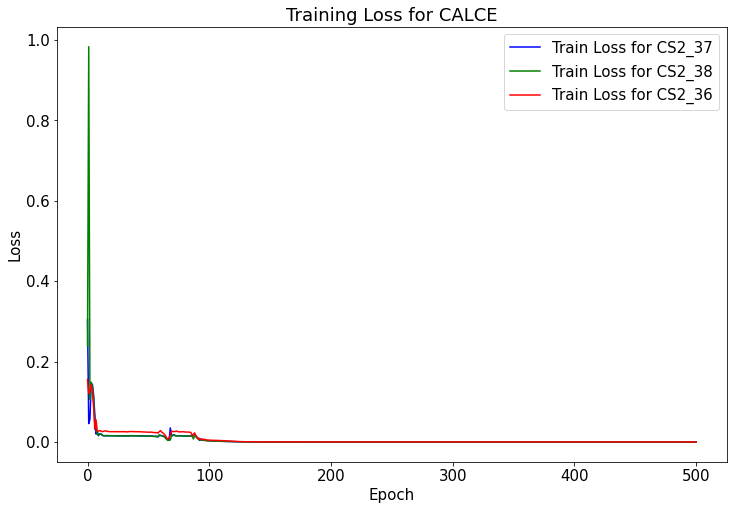

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8))
color_list = ['b', 'g', 'r']

for name, color in zip(train_list_1, color_list):
    df_result = losses_1[name]
    x = np.arange(0, len(df_result))
    ax.plot(x, df_result, color, label = 'Train Loss for '+name)
ax.set(xlabel = 'Epoch', ylabel = 'Loss', title = 'Training Loss for CALCE')
plt.legend()

Battery: CS2_35 | Dataset Length: 882 | Input Length: 617 | Target Length: 265
trained on device: cuda
hidden size: 32 | learning rate: 0.01 | teacher-forcing ratio: 0.1 | test split: 0.7
MAE: 0.0592 | RMSE: 0.0758 | Accuracy: 87.82


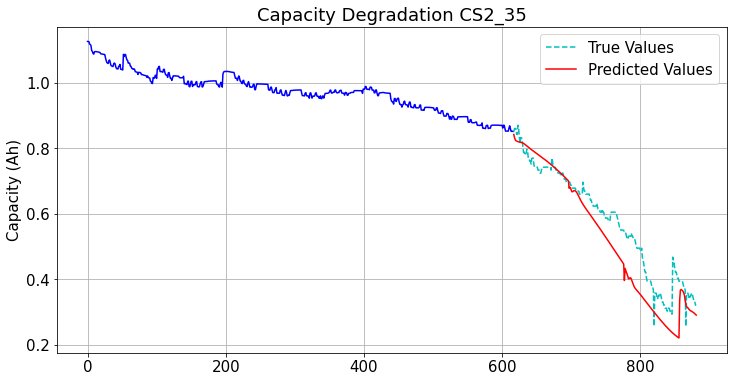

In [ ]:
# inference mode on CS2_35
battery_name = 'CS2_35'
scaler = scaler_0

df = Battery[battery_name]['capacity']
x_cap = np.array(list(df)).reshape(-1, 1)
x_cap_norm = scaler.transform(x_cap)
x_cap_norm = x_cap_norm.tolist()
train_split = 0.70
x_input = x_cap_norm[0:int(len(x_cap_norm)*train_split)]
x_target = x_cap_norm[int(len(x_cap_norm)*train_split):]
print(f'Battery: {battery_name} | Dataset Length: {len(x_cap_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 
print(f"trained on device: {device}")
# input history
train_period = 80
# prediction length
prediction_period = 80

X = inference_window(x_input, train_period)
X = np.array(X)
X = np.squeeze(X)
x_in = to_tensor(X)
x_in = x_in.to(device)
output = []

model_1.eval()
max_length = len(x_cap_norm) - (len(x_cap_norm) % train_period) + train_period
#max_length = 5000
while len(x_input) <= max_length:
    predicted = model_1.predict(x_in, prediction_period)
    pred_seq = predicted[:, -1, :].view(-1).tolist()   
    for i in range(len(pred_seq)):
        x_input.append([pred_seq[i]])
        output.append([pred_seq[i]])
    X = inference_window(x_input, train_period)
    X = np.array(X)
    X = np.squeeze(X)
    x_in = to_tensor(X)
    x_in = x_in.to(device)    


x_cap = x_cap.tolist()
x_input = x_cap[0:int(len(x_cap)*train_split)]
x_target = x_cap[int(len(x_cap)*train_split):]
output = scaler.inverse_transform(np.array(output).reshape(-1,1))
output = output.tolist()
acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
mae = mean_absolute_error(output[:len(x_target)], x_target)
mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))
#tfr = .1
#lr = .005
print(f"hidden size: {hidden_size} | learning rate: {lr} | teacher-forcing ratio: {tfr} | test split: {train_split}")
print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")

import matplotlib as mpl
x = range(0, len(x_cap_norm))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(12,6))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Dataset Length: 882 | Input Length: 529 | Target Length: 353
MAE: 0.0430 | RMSE: 0.0565 | Accuracy: 91.08


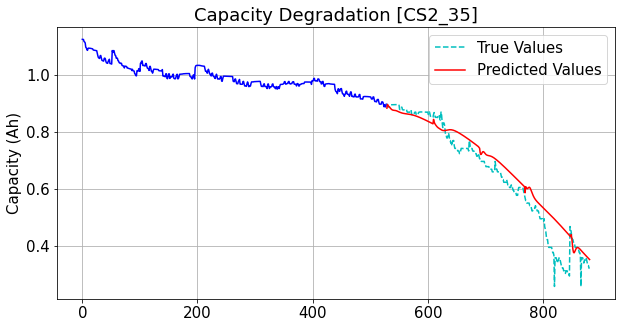

In [ ]:
# inference mode on CS2_35
df_cap35 = Battery['CS2_35']['capacity']
x_cap35 = np.array(list(df_cap35)).reshape(-1, 1)
x_cap35_norm = scaler_0.transform(x_cap35)
x_cap35_norm = x_cap35_norm.tolist()
train_split = 0.70
x_input = x_cap35_norm[0:int(len(x_cap35_norm)*train_split)]
x_target = x_cap35_norm[int(len(x_cap35_norm)*train_split):]
print(f'Dataset Length: {len(x_cap35_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 

# input history
train_period = 80
# prediction length
prediction_period = 80

X = inference_window(x_input, train_period)
X = np.array(X)
X = np.squeeze(X)
x_in = to_tensor(X)
output = []

model_1.eval()
max_length = len(x_cap35_norm) - (len(x_cap35_norm) % train_period) + train_period
#max_length = 5000
while len(x_input) <= max_length:
    predicted = model_1.predict(x_in, prediction_period)
    pred_seq = predicted[:, -1, :].view(-1).tolist()   
    for i in range(len(pred_seq)):
        x_input.append([pred_seq[i]])
        output.append([pred_seq[i]])
    X = inference_window(x_input, train_period)
    X = np.array(X)
    X = np.squeeze(X)
    x_in = to_tensor(X)    


x_cap35 = x_cap35.tolist()
x_input = x_cap35[0:int(len(x_cap35)*train_split)]
x_target = x_cap35[int(len(x_cap35)*train_split):]
output = scaler_0.inverse_transform(np.array(output).reshape(-1,1))
output = output.tolist()
acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
mae = mean_absolute_error(output[:len(x_target)], x_target)
mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))
print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")

import matplotlib as mpl
x = range(0, len(x_cap35_norm))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation [CS2_35]')
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Dataset Length: 996 | Input Length: 697 | Target Length: 299
MAE: 0.0196 | RMSE: 0.0272 | Accuracy: 96.09


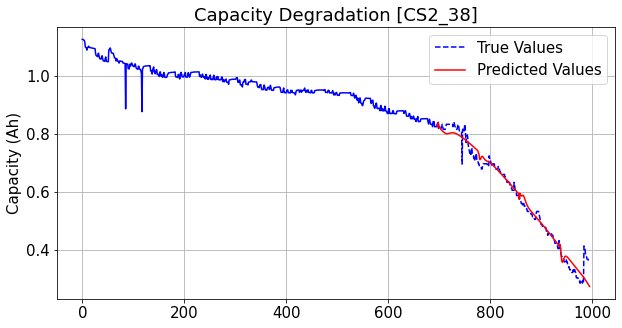

In [ ]:
# inference mode on CS2_38
df_cap38 = Battery['CS2_38']['capacity']
x_cap38 = np.array(list(df_cap38)).reshape(-1, 1)
x_cap38_norm = scaler_0.transform(x_cap38)
x_cap38_norm = x_cap38_norm.tolist()
train_split = 0.70
x_input = x_cap38_norm[0:int(len(x_cap38_norm)*train_split)]
x_target = x_cap38_norm[int(len(x_cap38_norm)*train_split):]
print(f'Dataset Length: {len(x_cap38_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 

# input history
train_period = 80
# prediction length
prediction_period = 80

X = inference_window(x_input, train_period)
X = np.array(X)
X = np.squeeze(X)
x_in = to_tensor(X)
output = []

model_1.eval()
max_length = len(x_cap38_norm) - (len(x_cap38_norm) % train_period) + train_period
#max_length = 5000
while len(x_input) <= max_length:
    predicted = model_1.predict(x_in, prediction_period)
    pred_seq = predicted[:, -1, :].view(-1).tolist()   
    for i in range(len(pred_seq)):
        x_input.append([pred_seq[i]])
        output.append([pred_seq[i]])
    X = inference_window(x_input, train_period)
    X = np.array(X)
    X = np.squeeze(X)
    x_in = to_tensor(X)    


x_cap38 = x_cap38.tolist()
x_input = x_cap38[0:int(len(x_cap38)*train_split)]
x_target = x_cap38[int(len(x_cap38)*train_split):]
output = scaler_0.inverse_transform(np.array(output).reshape(-1,1))
output = output.tolist()
acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
mae = mean_absolute_error(output[:len(x_target)], x_target)
mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))
print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")

import matplotlib as mpl
x = range(0, len(x_cap38_norm))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation [CS2_38]')
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "b--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Dataset Length: 972 | Input Length: 680 | Target Length: 292
MAE: 0.0397 | RMSE: 0.0448 | Accuracy: 92.16


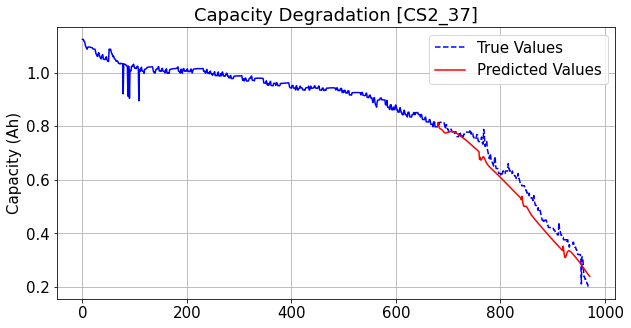

In [ ]:
# inference mode on CS2_37
df_cap37 = Battery['CS2_37']['capacity']
x_cap37 = np.array(list(df_cap37)).reshape(-1, 1)
x_cap37_norm = scaler_0.transform(x_cap37)
x_cap37_norm = x_cap37_norm.tolist()
train_split = 0.70
x_input = x_cap37_norm[0:int(len(x_cap37_norm)*train_split)]
x_target = x_cap37_norm[int(len(x_cap37_norm)*train_split):]
print(f'Dataset Length: {len(x_cap37_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 

# input history
train_period = 80
# prediction length
prediction_period = 80

X = inference_window(x_input, train_period)
X = np.array(X)
X = np.squeeze(X)
x_in = to_tensor(X)
output = []

model_1.eval()
max_length = len(x_cap37_norm) - (len(x_cap37_norm) % train_period) + train_period
#max_length = 5000
while len(x_input) <= max_length:
    predicted = model_1.predict(x_in, prediction_period)
    pred_seq = predicted[:, -1, :].view(-1).tolist()   
    for i in range(len(pred_seq)):
        x_input.append([pred_seq[i]])
        output.append([pred_seq[i]])
    X = inference_window(x_input, train_period)
    X = np.array(X)
    X = np.squeeze(X)
    x_in = to_tensor(X)    


x_cap37 = x_cap37.tolist()
x_input = x_cap37[0:int(len(x_cap37)*train_split)]
x_target = x_cap37[int(len(x_cap37)*train_split):]
output = scaler_0.inverse_transform(np.array(output).reshape(-1,1))
output = output.tolist()
acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
mae = mean_absolute_error(output[:len(x_target)], x_target)
mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))
print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")

import matplotlib as mpl
x = range(0, len(x_cap37_norm))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation [CS2_37]')
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "b--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Dataset Length: 936 | Input Length: 655 | Target Length: 281
MAE: 0.0344 | RMSE: 0.0490 | Accuracy: 87.97


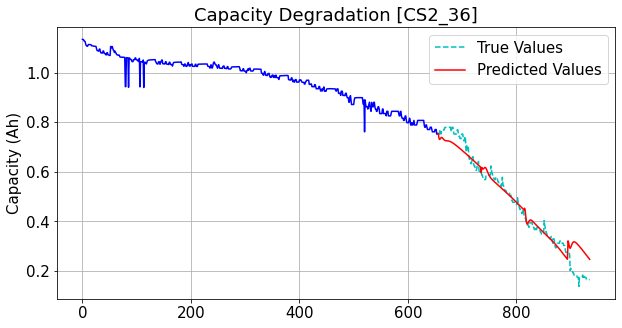

In [ ]:
# inference mode on CS2_36
df_cap36 = Battery['CS2_36']['capacity']
x_cap36 = np.array(list(df_cap36)).reshape(-1, 1)
x_cap36_norm = scaler_0.transform(x_cap36)
x_cap36_norm = x_cap36_norm.tolist()
train_split = 0.70
x_input = x_cap36_norm[0:int(len(x_cap36_norm)*train_split)]
x_target = x_cap36_norm[int(len(x_cap36_norm)*train_split):]
print(f'Dataset Length: {len(x_cap36_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 

# input history
train_period = 80
# prediction length
prediction_period = 80

X = inference_window(x_input, train_period)
X = np.array(X)
X = np.squeeze(X)
x_in = to_tensor(X)
output = []

model_1.eval()
max_length = len(x_cap36_norm) - (len(x_cap36_norm) % train_period) + train_period
#max_length = 5000
while len(x_input) <= max_length:
    predicted = model_1.predict(x_in, prediction_period)
    pred_seq = predicted[:, -1, :].view(-1).tolist()   
    for i in range(len(pred_seq)):
        x_input.append([pred_seq[i]])
        output.append([pred_seq[i]])
    X = inference_window(x_input, train_period)
    X = np.array(X)
    X = np.squeeze(X)
    x_in = to_tensor(X)    


x_cap36 = x_cap36.tolist()
x_input = x_cap36[0:int(len(x_cap36)*train_split)]
x_target = x_cap36[int(len(x_cap36)*train_split):]
output = scaler_0.inverse_transform(np.array(output).reshape(-1,1))
output = output.tolist()
acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
mae = mean_absolute_error(output[:len(x_target)], x_target)
mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))
print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")

import matplotlib as mpl
x = range(0, len(x_cap36_norm))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation [CS2_36]')
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

### Saving the Model

In [ ]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "LSTMCALCE_363738.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/LSTMCALCE_363738.pth


## Train set CS2_35, CS2_37, CS2_38 | Test set CS2_36

In [ ]:
x_cap35 = np.array(list(df_cap35)).reshape(-1, 1)
x_cap37 = np.array(list(df_cap37)).reshape(-1, 1)
x_cap38 = np.array(list(df_cap38)).reshape(-1, 1)
# Observe the max and min values
max_35 = max(x_cap35)
min_35 = min(x_cap35)

max_37 = max(x_cap37)
min_37 = min(x_cap37)

max_38 = max(x_cap38)
min_38 = min(x_cap38)

max_35, min_35, max_37, min_37, max_38, min_38

(array([1.12638451]),
 array([0.25667719]),
 array([1.12425147]),
 array([0.20170847]),
 array([1.12696392]),
 array([0.28418502]))

In [ ]:
# CS2_36 had the max and min values so will use that as the scaler
#scaler_1 = MinMaxScaler(feature_range=(0,1))
#scaler_1 = scaler_0.fit(x_cap37)
x_cap35_norm = scaler_0.transform(x_cap35)
x_cap37_norm = scaler_0.transform(x_cap37)
x_cap38_norm = scaler_0.transform(x_cap38)

# transform it back to type list
x_cap35_norm = x_cap35_norm.tolist()
x_cap37_norm = x_cap37_norm.tolist()
x_cap38_norm = x_cap38_norm.tolist()

In [ ]:
# input history
train_period = 80
# prediction length
prediction_period = 80
# stride (make it similar to prediction_period)
stride = 1

# call sliding window function
X_35, Y_35 = sliding_window(x_cap35_norm, train_period, prediction_period, stride)
X_37, Y_37 = sliding_window(x_cap37_norm, train_period, prediction_period, stride)
X_38, Y_38 = sliding_window(x_cap38_norm, train_period, prediction_period, stride)

X_35, Y_35 = np.array(X_35), np.array(Y_35)
X_37, Y_37 = np.array(X_37), np.array(Y_37)
X_38, Y_38 = np.array(X_38), np.array(Y_38)

X_35, Y_35 = np.squeeze(X_35), np.squeeze(Y_35)
X_37, Y_37 = np.squeeze(X_37), np.squeeze(Y_37)
X_38, Y_38 = np.squeeze(X_38), np.squeeze(Y_38)

X_35.shape, Y_35.shape, X_37.shape, Y_37.shape, X_38.shape, Y_38.shape

((723, 80), (723, 80), (813, 80), (813, 80), (837, 80), (837, 80))

In [ ]:
# put array pairs into a dictionary for easier access when training
train_battery_2 = {}
CS2_35 = {}
CS2_35['X'] = X_35
CS2_35['Y'] = Y_35 
train_battery_2['CS2_35'] = CS2_35
CS2_37 = {}
CS2_37['X'] = X_37
CS2_37['Y'] = Y_37 
train_battery_2['CS2_37'] = CS2_37
CS2_38 = {}
CS2_38['X'] = X_38
CS2_38['Y'] = Y_38 
train_battery_2['CS2_38'] = CS2_38

In [ ]:
train_list_2 = ['CS2_35', 'CS2_37', 'CS2_38']

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# lstm hidden size 
hidden_size = 32
# learning rate
lr = 0.01
# teacher-forcing ratio
tfr = 0.1
# training epochs
epochs = 500
# input history
train_period = 80
# prediction length
prediction_period = 80

model_2 = EncoderDecoder(hidden_size = hidden_size)
model_2.to(device)

model_2.train()
losses_2 = model_2.train_model(train_battery=train_battery_2,
                             train_list=train_list_2,
                             epochs=epochs,
                             target_len=prediction_period,
                             method='mixed_teacher_forcing',
                             tfr = tfr,
                             lr = lr)

Battery: CS2_35 |Epoch 0/500: 0.2141
Battery: CS2_37 |Epoch 0/500: 0.1552
Battery: CS2_38 |Epoch 0/500: 0.1136
Battery: CS2_35 |Epoch 100/500: 0.0133
Battery: CS2_37 |Epoch 100/500: 0.0119
Battery: CS2_38 |Epoch 100/500: 0.0112
Battery: CS2_35 |Epoch 200/500: 0.0154
Battery: CS2_37 |Epoch 200/500: 0.015
Battery: CS2_38 |Epoch 200/500: 0.0144
Battery: CS2_35 |Epoch 300/500: 0.0103
Battery: CS2_37 |Epoch 300/500: 0.0092
Battery: CS2_38 |Epoch 300/500: 0.0051
Battery: CS2_35 |Epoch 400/500: 0.0005
Battery: CS2_37 |Epoch 400/500: 0.0002
Battery: CS2_38 |Epoch 400/500: 0.0003
Battery: CS2_35 |Epoch 500/500: 0.0004
Battery: CS2_37 |Epoch 500/500: 0.0003
Battery: CS2_38 |Epoch 500/500: 0.0002


Battery: CS2_36 | Dataset Length: 936 | Input Length: 561 | Target Length: 375
trained on device: cuda
hidden size: 32 | learning rate: 0.01 | teacher-forcing ratio: 0.1 | test split: 0.6
MAE: 0.0453 | RMSE: 0.0711 | Accuracy: 83.65


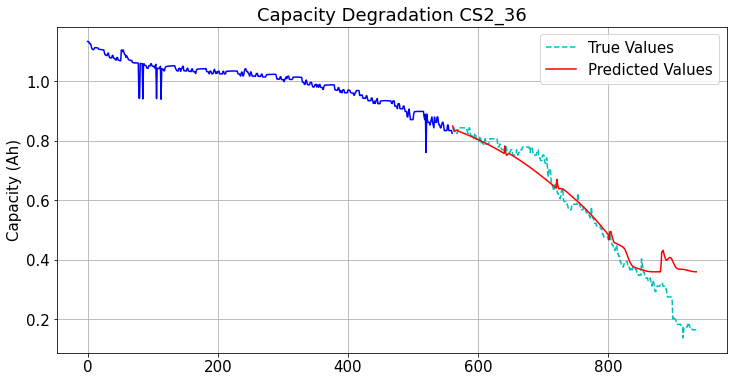

In [ ]:
# inference mode on CS2_36
battery_name = 'CS2_36'
scaler = scaler_0

df = Battery[battery_name]['capacity']
x_cap = np.array(list(df)).reshape(-1, 1)
x_cap_norm = scaler.transform(x_cap)
x_cap_norm = x_cap_norm.tolist()
train_split = 0.60
x_input = x_cap_norm[0:int(len(x_cap_norm)*train_split)]
x_target = x_cap_norm[int(len(x_cap_norm)*train_split):]
print(f'Battery: {battery_name} | Dataset Length: {len(x_cap_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 
print(f"trained on device: {device}")
# input history
train_period = 80
# prediction length
prediction_period = 80

X = inference_window(x_input, train_period)
X = np.array(X)
X = np.squeeze(X)
x_in = to_tensor(X)
x_in = x_in.to(device)
output = []

model_2.eval()
max_length = len(x_cap_norm) - (len(x_cap_norm) % train_period) + train_period
#max_length = 5000
while len(x_input) <= max_length:
    predicted = model_2.predict(x_in, prediction_period)
    pred_seq = predicted[:, -1, :].view(-1).tolist()   
    for i in range(len(pred_seq)):
        x_input.append([pred_seq[i]])
        output.append([pred_seq[i]])
    X = inference_window(x_input, train_period)
    X = np.array(X)
    X = np.squeeze(X)
    x_in = to_tensor(X)
    x_in = x_in.to(device)    


x_cap = x_cap.tolist()
x_input = x_cap[0:int(len(x_cap)*train_split)]
x_target = x_cap[int(len(x_cap)*train_split):]
output = scaler.inverse_transform(np.array(output).reshape(-1,1))
output = output.tolist()
acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
mae = mean_absolute_error(output[:len(x_target)], x_target)
mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))
#tfr = .1
#lr = .005
print(f"hidden size: {hidden_size} | learning rate: {lr} | teacher-forcing ratio: {tfr} | test split: {train_split}")
print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")

import matplotlib as mpl
x = range(0, len(x_cap_norm))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(12,6))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Dataset Length: 936 | Input Length: 748 | Target Length: 188
MAE: 0.0749 | RMSE: 0.1068 | Accuracy: 67.57


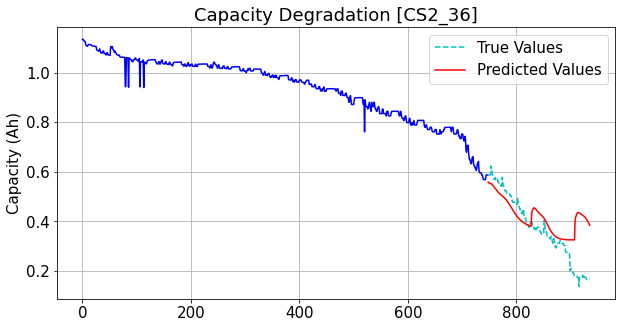

In [ ]:
# inference mode on CS2_36
df_cap36 = Battery['CS2_36']['capacity']
x_cap36 = np.array(list(df_cap36)).reshape(-1, 1)
x_cap36_norm = scaler_1.transform(x_cap36)
x_cap36_norm = x_cap36_norm.tolist()
train_split = 0.80
x_input = x_cap36_norm[0:int(len(x_cap36_norm)*train_split)]
x_target = x_cap36_norm[int(len(x_cap36_norm)*train_split):]
print(f'Dataset Length: {len(x_cap36_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 

# input history
train_period = 80
# prediction length
prediction_period = 80

X = inference_window(x_input, train_period)
X = np.array(X)
X = np.squeeze(X)
x_in = to_tensor(X)
output = []

model_2.eval()
max_length = len(x_cap36_norm) - (len(x_cap36_norm) % train_period) + train_period
#max_length = 5000
while len(x_input) <= max_length:
    predicted = model_2.predict(x_in, prediction_period)
    pred_seq = predicted[:, -1, :].view(-1).tolist()   
    for i in range(len(pred_seq)):
        x_input.append([pred_seq[i]])
        output.append([pred_seq[i]])
    X = inference_window(x_input, train_period)
    X = np.array(X)
    X = np.squeeze(X)
    x_in = to_tensor(X)    


x_cap36 = x_cap36.tolist()
x_input = x_cap36[0:int(len(x_cap36)*train_split)]
x_target = x_cap36[int(len(x_cap36)*train_split):]
output = scaler_1.inverse_transform(np.array(output).reshape(-1,1))
output = output.tolist()
acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
mae = mean_absolute_error(output[:len(x_target)], x_target)
mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))
print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")

import matplotlib as mpl
x = range(0, len(x_cap36_norm))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation [CS2_36]')
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Dataset Length: 996 | Input Length: 597 | Target Length: 399
MAE: 0.0237 | RMSE: 0.0296 | Accuracy: 95.79


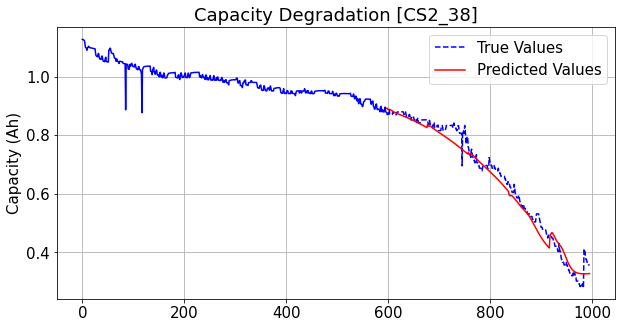

In [ ]:
# inference mode on CS2_38
df_cap38 = Battery['CS2_38']['capacity']
x_cap38 = np.array(list(df_cap38)).reshape(-1, 1)
x_cap38_norm = scaler_1.transform(x_cap38)
x_cap38_norm = x_cap38_norm.tolist()
train_split = 0.60
x_input = x_cap38_norm[0:int(len(x_cap38_norm)*train_split)]
x_target = x_cap38_norm[int(len(x_cap38_norm)*train_split):]
print(f'Dataset Length: {len(x_cap38_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 

# input history
train_period = 80
# prediction length
prediction_period = 80

X = inference_window(x_input, train_period)
X = np.array(X)
X = np.squeeze(X)
x_in = to_tensor(X)
output = []

model_2.eval()
max_length = len(x_cap38_norm) - (len(x_cap38_norm) % train_period) + train_period
#max_length = 5000
while len(x_input) <= max_length:
    predicted = model_2.predict(x_in, prediction_period)
    pred_seq = predicted[:, -1, :].view(-1).tolist()   
    for i in range(len(pred_seq)):
        x_input.append([pred_seq[i]])
        output.append([pred_seq[i]])
    X = inference_window(x_input, train_period)
    X = np.array(X)
    X = np.squeeze(X)
    x_in = to_tensor(X)    


x_cap38 = x_cap38.tolist()
x_input = x_cap38[0:int(len(x_cap38)*train_split)]
x_target = x_cap38[int(len(x_cap38)*train_split):]
output = scaler_1.inverse_transform(np.array(output).reshape(-1,1))
output = output.tolist()
acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
mae = mean_absolute_error(output[:len(x_target)], x_target)
mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))
print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")

import matplotlib as mpl
x = range(0, len(x_cap38_norm))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation [CS2_38]')
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "b--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

## Train set CS2_35, CS2_36, CS2_38 | Test set CS2_37


In [ ]:
x_cap35 = np.array(list(df_cap35)).reshape(-1, 1)
x_cap36 = np.array(list(df_cap36)).reshape(-1, 1)
x_cap38 = np.array(list(df_cap38)).reshape(-1, 1)
# Observe the max and min values
max_35 = max(x_cap35)
min_35 = min(x_cap35)

max_36 = max(x_cap36)
min_36 = min(x_cap36)

max_38 = max(x_cap38)
min_38 = min(x_cap38)

max_35, min_35, max_36, min_36, max_38, min_38

(array([1.12638451]),
 array([0.25667719]),
 array([1.13380661]),
 array([0.13754796]),
 array([1.12696392]),
 array([0.28418502]))

In [ ]:
# CS2_36 had the max and min values so will use that as the scaler
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaler_2 = scaler_0.fit(x_cap36)
x_cap35_norm = scaler_2.transform(x_cap35)
x_cap36_norm = scaler_2.transform(x_cap36)
x_cap38_norm = scaler_2.transform(x_cap38)

# transform it back to type list
x_cap35_norm = x_cap35_norm.tolist()
x_cap36_norm = x_cap36_norm.tolist()
x_cap38_norm = x_cap38_norm.tolist()

In [ ]:
# input history
train_period = 80
# prediction length
prediction_period = 80
# stride (make it similar to prediction_period)
stride = 1

# call sliding window function
X_35, Y_35 = sliding_window(x_cap35_norm, train_period, prediction_period, stride)
X_36, Y_36 = sliding_window(x_cap36_norm, train_period, prediction_period, stride)
X_38, Y_38 = sliding_window(x_cap38_norm, train_period, prediction_period, stride)

X_35, Y_35 = np.array(X_35), np.array(Y_35)
X_36, Y_36 = np.array(X_36), np.array(Y_36)
X_38, Y_38 = np.array(X_38), np.array(Y_38)

X_35, Y_35 = np.squeeze(X_35), np.squeeze(Y_35)
X_36, Y_36 = np.squeeze(X_36), np.squeeze(Y_36)
X_38, Y_38 = np.squeeze(X_38), np.squeeze(Y_38)

X_35.shape, Y_35.shape, X_36.shape, Y_36.shape, X_38.shape, Y_38.shape

((723, 80), (723, 80), (777, 80), (777, 80), (837, 80), (837, 80))

In [ ]:
# put array pairs into a dictionary for easier access when training
train_battery_3 = {}
CS2_35 = {}
CS2_35['X'] = X_35
CS2_35['Y'] = Y_35 
train_battery_3['CS2_35'] = CS2_35
CS2_36 = {}
CS2_36['X'] = X_36
CS2_36['Y'] = Y_36 
train_battery_3['CS2_36'] = CS2_36
CS2_38 = {}
CS2_38['X'] = X_38
CS2_38['Y'] = Y_38 
train_battery_3['CS2_38'] = CS2_38

In [ ]:
train_list_3 = ['CS2_35', 'CS2_38', 'CS2_36']

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# lstm hidden size 
hidden_size = 32
# training epochs
epochs = 500
# input history
train_period = 80
# prediction length
prediction_period = 80

model_3 = EncoderDecoder(hidden_size = hidden_size)

model_3.train()
losses_3 = model_3.train_model(train_battery=train_battery_3,
                             train_list=train_list_3,
                             epochs=epochs,
                             target_len=prediction_period,
                             method='mixed_teacher_forcing',
                             tfr = .05,
                             lr = .005)

Battery: CS2_35 |Epoch 0/500: 0.3223
Battery: CS2_38 |Epoch 0/500: 0.2797
Battery: CS2_36 |Epoch 0/500: 0.227
Battery: CS2_35 |Epoch 100/500: 0.0176
Battery: CS2_38 |Epoch 100/500: 0.0151
Battery: CS2_36 |Epoch 100/500: 0.0286
Battery: CS2_35 |Epoch 200/500: 0.0174
Battery: CS2_38 |Epoch 200/500: 0.0192
Battery: CS2_36 |Epoch 200/500: 0.0287
Battery: CS2_35 |Epoch 300/500: 0.0006
Battery: CS2_38 |Epoch 300/500: 0.0004
Battery: CS2_36 |Epoch 300/500: 0.0007
Battery: CS2_35 |Epoch 400/500: 0.0005
Battery: CS2_38 |Epoch 400/500: 0.0003
Battery: CS2_36 |Epoch 400/500: 0.0004
Battery: CS2_35 |Epoch 500/500: 0.0005
Battery: CS2_38 |Epoch 500/500: 0.0003
Battery: CS2_36 |Epoch 500/500: 0.0004


In [ ]:
train_list_3 = ['CS2_35', 'CS2_38', 'CS2_36']

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# lstm hidden size 
hidden_size = 128
# learning rate
lr = 0.01
# teacher-forcing ratio
tfr = 0.1
# training epochs
epochs = 500
# input history
train_period = 80
# prediction length
prediction_period = 80

model_3 = EncoderDecoder(hidden_size = hidden_size)
model_3.to(device)

model_3.train()
losses_3 = model_3.train_model(train_battery=train_battery_3,
                             train_list=train_list_3,
                             epochs=epochs,
                             target_len=prediction_period,
                             method='mixed_teacher_forcing',
                             tfr = tfr,
                             lr = lr)

Battery: CS2_35 |Epoch 0/500: 0.3092
Battery: CS2_38 |Epoch 0/500: 0.1739
Battery: CS2_36 |Epoch 0/500: 0.3079
Battery: CS2_35 |Epoch 100/500: 0.0005
Battery: CS2_38 |Epoch 100/500: 0.0003
Battery: CS2_36 |Epoch 100/500: 0.0005
Battery: CS2_35 |Epoch 200/500: 0.0004
Battery: CS2_38 |Epoch 200/500: 0.0003
Battery: CS2_36 |Epoch 200/500: 0.0004
Battery: CS2_35 |Epoch 300/500: 0.0004
Battery: CS2_38 |Epoch 300/500: 0.0003
Battery: CS2_36 |Epoch 300/500: 0.0004
Battery: CS2_35 |Epoch 400/500: 0.0004
Battery: CS2_38 |Epoch 400/500: 0.0003
Battery: CS2_36 |Epoch 400/500: 0.0004
Battery: CS2_35 |Epoch 500/500: 0.0004
Battery: CS2_38 |Epoch 500/500: 0.0003
Battery: CS2_36 |Epoch 500/500: 0.0003


Battery: CS2_37 | Dataset Length: 972 | Input Length: 583 | Target Length: 389
MAE: 0.0198 | RMSE: 0.0250 | Accuracy: 96.10


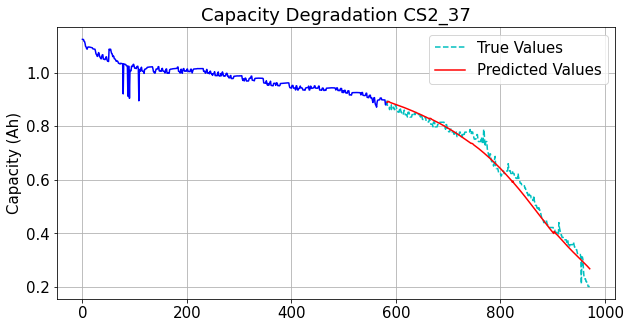

In [ ]:
# inference mode on CS2_37
battery_name = 'CS2_37'
scaler = scaler_2

df = Battery[battery_name]['capacity']
x_cap = np.array(list(df)).reshape(-1, 1)
x_cap_norm = scaler.transform(x_cap)
x_cap_norm = x_cap_norm.tolist()
train_split = 0.60
x_input = x_cap_norm[0:int(len(x_cap_norm)*train_split)]
x_target = x_cap_norm[int(len(x_cap_norm)*train_split):]
print(f'Battery: {battery_name} | Dataset Length: {len(x_cap_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 

# input history
train_period = 80
# prediction length
prediction_period = 80

X = inference_window(x_input, train_period)
X = np.array(X)
X = np.squeeze(X)
x_in = to_tensor(X)
x_in = x_in.to(device)
output = []

model_3.eval()
max_length = len(x_cap_norm) - (len(x_cap_norm) % train_period) + train_period
#max_length = 5000
while len(x_input) <= max_length:
    predicted = model_3.predict(x_in, prediction_period)
    pred_seq = predicted[:, -1, :].view(-1).tolist()   
    for i in range(len(pred_seq)):
        x_input.append([pred_seq[i]])
        output.append([pred_seq[i]])
    X = inference_window(x_input, train_period)
    X = np.array(X)
    X = np.squeeze(X)
    x_in = to_tensor(X)
    x_in = x_in.to(device)    


x_cap = x_cap.tolist()
x_input = x_cap[0:int(len(x_cap)*train_split)]
x_target = x_cap[int(len(x_cap)*train_split):]
output = scaler.inverse_transform(np.array(output).reshape(-1,1))
output = output.tolist()
acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
mae = mean_absolute_error(output[:len(x_target)], x_target)
mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))
print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")

import matplotlib as mpl
x = range(0, len(x_cap_norm))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

In [ ]:
output

[[0.8750404128615398],
 [0.8762762636162399],
 [0.8864444198785075],
 [0.8861514902334501],
 [0.8790265837947278],
 [0.8694901294509926],
 [0.871687369006317],
 [0.8750196292864799],
 [0.8742303284873509],
 [0.8730169833753585],
 [0.8718895635008276],
 [0.8708854792988661],
 [0.8699443396385143],
 [0.8689024293299439],
 [0.8675179463227445],
 [0.8657250957564412],
 [0.8636960843958152],
 [0.8616541872186522],
 [0.8596786193367515],
 [0.8576772204401336],
 [0.8554846720346083],
 [0.8529761539065307],
 [0.8501273195822593],
 [0.847012158589007],
 [0.8437686738651711],
 [0.8405534548034165],
 [0.8375058107382871],
 [0.8347256215933562],
 [0.8322693593111433],
 [0.8301542445681266],
 [0.8283698261951333],
 [0.8268887292547272],
 [0.8256754435243778],
 [0.8246923804240482],
 [0.8239038515862785],
 [0.8232771377257604],
 [0.822783260600696],
 [0.8223972205393705],
 [0.822097818295223],
 [0.821867239375345],
 [0.8216906383689796],
 [0.821556079565878],
 [0.8214540619031557],
 [0.8213769251488

Battery: CS2_36 | Dataset Length: 936 | Input Length: 842 | Target Length: 94
MAE: 0.0362 | RMSE: 0.0590 | Accuracy: 81.25


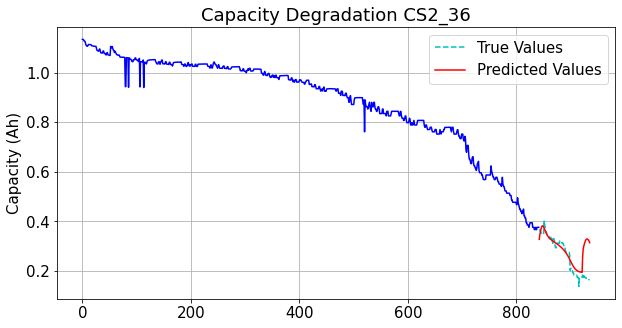

In [ ]:
# inference mode on CS2_37
battery_name = 'CS2_36'
scaler = scaler_2

df = Battery[battery_name]['capacity']
x_cap = np.array(list(df)).reshape(-1, 1)
x_cap_norm = scaler.transform(x_cap)
x_cap_norm = x_cap_norm.tolist()
train_split = 0.90
x_input = x_cap_norm[0:int(len(x_cap_norm)*train_split)]
x_target = x_cap_norm[int(len(x_cap_norm)*train_split):]
print(f'Battery: {battery_name} | Dataset Length: {len(x_cap_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 

# input history
train_period = 80
# prediction length
prediction_period = 80

X = inference_window(x_input, train_period)
X = np.array(X)
X = np.squeeze(X)
x_in = to_tensor(X)
output = []

model_3.eval()
max_length = len(x_cap_norm) - (len(x_cap_norm) % train_period) + train_period
#max_length = 5000
while len(x_input) <= max_length:
    predicted = model_3.predict(x_in, prediction_period)
    pred_seq = predicted[:, -1, :].view(-1).tolist()   
    for i in range(len(pred_seq)):
        x_input.append([pred_seq[i]])
        output.append([pred_seq[i]])
    X = inference_window(x_input, train_period)
    X = np.array(X)
    X = np.squeeze(X)
    x_in = to_tensor(X)    


x_cap = x_cap.tolist()
x_input = x_cap[0:int(len(x_cap)*train_split)]
x_target = x_cap[int(len(x_cap)*train_split):]
output = scaler.inverse_transform(np.array(output).reshape(-1,1))
output = output.tolist()
acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
mae = mean_absolute_error(output[:len(x_target)], x_target)
mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))
print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")

import matplotlib as mpl
x = range(0, len(x_cap_norm))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

## Saving the models

In [ ]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAMES = ['LSTMCALCE_32_38.pth', 'LSTMCALCE_32_35.pth', 'LSTMCALCE_32_36.pth', 'LSTMCALCE_128_37.pth'] 
state_dicts = [model_0.state_dict(), model_1.state_dict(), model_2.state_dict(), model_3.state_dict()]


# 3. Save the model state dict 
for model_name, state_model in zip(MODEL_NAMES, state_dicts):
    MODEL_SAVE_PATH = MODEL_PATH / model_name
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=state_model, # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/LSTMCALCE_32_38.pth
Saving model to: models/LSTMCALCE_32_35.pth
Saving model to: models/LSTMCALCE_32_36.pth
Saving model to: models/LSTMCALCE_128_37.pth


## Saving pytorch tensors

In [ ]:
!rm -rf tensors/

In [ ]:
def inference_window(x_input, train_period):
    rem = len(x_input) % train_period
    index = abs(rem - len(x_input))
    num_samples = index // train_period
    x = []
    init_x = -index
    for i in range(num_samples):
        '''
        x.append(x_input[-index-a: a])
        a = a + 100
        index =
        '''
        fin_x = init_x + train_period
        if fin_x == 0:
            x.append(x_input[init_x:])
        else:
            x.append(x_input[init_x:fin_x])
        init_x = fin_x
                      
    return x

In [ ]:
# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()

In [ ]:
# Method to save tensor file
from pickle import load

battery_list = ['CS2_35','CS2_36', 'CS2_37', 'CS2_38']
#battery_name = 'CS2_36'
scaler = scaler = load(open('scaler.pkl', 'rb'))
train_split = [0.50, 0.60, 0.70, 0.80]
# input history
train_period = 80
# prediction length
prediction_period = 80

for name in battery_list:
    for split in train_split:
        df = Battery[name]['capacity']
        x_cap = np.array(list(df)).reshape(-1, 1)
        x_cap_norm = scaler.transform(x_cap)
        x_cap_norm = x_cap_norm.tolist()

        x_input = x_cap_norm[0:int(len(x_cap_norm)*split)]
        x_target = x_cap_norm[int(len(x_cap_norm)*split):]    
        print(f'Battery: {name} | Dataset Length: {len(x_cap_norm)} | Input Length: {len(x_input)} | Target Length: {len(x_target)}') 

        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
        tensor_name = name + "_" + str(int(split*100)) + ".pt"
        tensor_path = "tensors/" + name + "/"
        torch.save(x_in, tensor_path + tensor_name)

Battery: CS2_35 | Dataset Length: 882 | Input Length: 441 | Target Length: 441
Battery: CS2_35 | Dataset Length: 882 | Input Length: 529 | Target Length: 353
Battery: CS2_35 | Dataset Length: 882 | Input Length: 617 | Target Length: 265
Battery: CS2_35 | Dataset Length: 882 | Input Length: 705 | Target Length: 177
Battery: CS2_36 | Dataset Length: 936 | Input Length: 468 | Target Length: 468
Battery: CS2_36 | Dataset Length: 936 | Input Length: 561 | Target Length: 375
Battery: CS2_36 | Dataset Length: 936 | Input Length: 655 | Target Length: 281
Battery: CS2_36 | Dataset Length: 936 | Input Length: 748 | Target Length: 188
Battery: CS2_37 | Dataset Length: 972 | Input Length: 486 | Target Length: 486
Battery: CS2_37 | Dataset Length: 972 | Input Length: 583 | Target Length: 389
Battery: CS2_37 | Dataset Length: 972 | Input Length: 680 | Target Length: 292
Battery: CS2_37 | Dataset Length: 972 | Input Length: 777 | Target Length: 195
Battery: CS2_38 | Dataset Length: 996 | Input Length

In [ ]:
battery_list = ['CS2_35','CS2_36', 'CS2_37', 'CS2_38']
train_split = [0.50, 0.60, 0.70, 0.80]
for name in battery_list:
    for split in train_split:
        df = Battery[name]['capacity']
        x_cap = np.array(list(df)).reshape(-1, 1)
        x_cap = x_cap.tolist()
        x_input = x_cap[0:int(len(x_cap)*split)]
        x_target = x_cap[int(len(x_cap)*split):]
        x_input = torch.Tensor(x_input)
        x_target = torch.Tensor(x_target)
        tensor_input = "input_" + name + "_" + str(int(split*100)) + ".pt"
        tensor_target = "target_" + name + "_" + str(int(split*100)) + ".pt"
        tensor_path = "tensors/" + name + "/"
        torch.save(x_input, tensor_path + tensor_input)
        torch.save(x_target, tensor_path + tensor_target)

In [ ]:
battery_list = ['CS2_35','CS2_36', 'CS2_37', 'CS2_38']
train_split = [0.50, 0.60, 0.70, 0.80]
scaler = scaler = load(open('scaler.pkl', 'rb'))
for name in battery_list:
    for split in train_split:
        df = Battery[name]['capacity']
        x_cap = np.array(list(df)).reshape(-1, 1)
        x_cap_norm = scaler.transform(x_cap)
        x_cap_norm = x_cap_norm.tolist()

        x_input = x_cap_norm[0:int(len(x_cap_norm)*split)]
        x_input = torch.Tensor(x_input)
        
        tensor_input = "scaledinput_" + name + "_" + str(int(split*100)) + ".pt"
        tensor_path = "tensors/" + name + "/"
        torch.save(x_input, tensor_path + tensor_input)

## Inference code

### CS2_35

#### hidden_size = 32

Test Split: 50%

MAE: 0.0941 | RMSE: 0.1179 | Accuracy: 83.25
True RUL: 199 | Prediction RUL: 174 | RUL Error: 25
Inference time on cpu: 0.628 seconds
Allocated memory: 1606.1 KiB


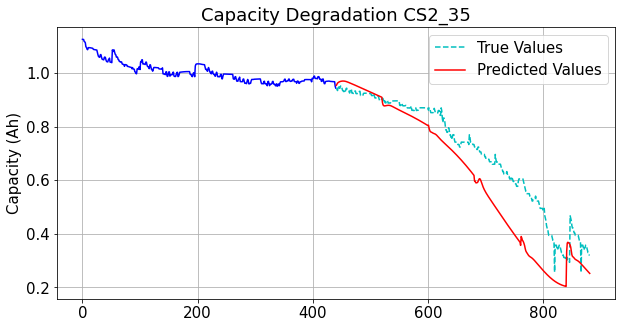

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()

def inference_window(x_input, train_period):
    rem = len(x_input) % train_period
    index = abs(rem - len(x_input))
    num_samples = index // train_period
    x = []
    init_x = -index
    for i in range(num_samples):
        '''
        x.append(x_input[-index-a: a])
        a = a + 100
        index =
        '''
        fin_x = init_x + train_period
        if fin_x == 0:
            x.append(x_input[init_x:])
        else:
            x.append(x_input[init_x:fin_x])
        init_x = fin_x
                      
    return x
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    test_path = "tensors/CS2_35/CS2_35_50.pt"
    #test_path = "tensors/CS2_35/CS2_35_60.pt"
    #test_path = "tensors/CS2_35/CS2_35_70.pt"

    # scaled input tensor path
    input_path = "tensors/CS2_35/scaledinput_CS2_35_50.pt"
    #input_path = "tensors/CS2_35/scaledinput_CS2_35_60.pt"
    #input_path = "tensors/CS2_35/scaledinput_CS2_35_70.pt"

    # target tensor path
    target_path = "tensors/CS2_35/target_CS2_35_50.pt"
    #target_path = "tensors/CS2_35/target_CS2_35_60.pt"
    #target_path = "tensors/CS2_35/target_CS2_35_70.pt"
    
    # model paths
    #model_save_path = "models/LSTMCALCE_128_35.pth"
    model_save_path = "models/LSTMCALCE_32_35.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    #hidden_size = 128
    hidden_size = 32

    # train_period
    train_period = 80
    # prediction length
    prediction_period = 80

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[0][1]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
input_path = "tensors/CS2_35/input_CS2_35_50.pt"
x_input = torch.load(input_path)
x_input = x_input.tolist()
#input_path = "tensors/CS2_35/scaledinput_CS2_35_60.pt"
#input_path = "tensors/CS2_35/scaledinput_CS2_35_70.pt"
#input_path = "tensors/CS2_35/scaledinput_CS2_35_80.pt"
import matplotlib as mpl
battery_name = 'CS2_35'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 60%

MAE: 0.1299 | RMSE: 0.1491 | Accuracy: 77.37
True RUL: 111 | Prediction RUL: 81 | RUL Error: 30
Inference time on cpu: 0.747 seconds
Allocated memory: 6739.7 KiB


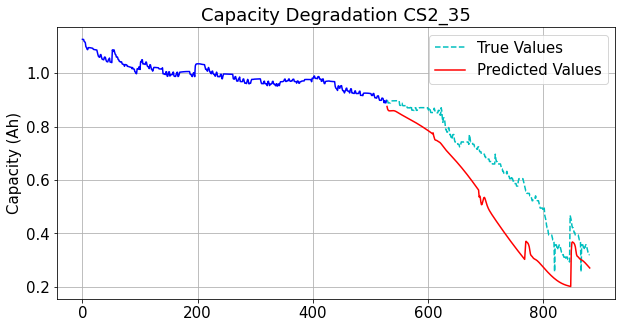

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_35/CS2_35_50.pt"
    test_path = "tensors/CS2_35/CS2_35_60.pt"
    #test_path = "tensors/CS2_35/CS2_35_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_35/scaledinput_CS2_35_50.pt"
    input_path = "tensors/CS2_35/scaledinput_CS2_35_60.pt"
    #input_path = "tensors/CS2_35/scaledinput_CS2_35_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_35/target_CS2_35_50.pt"
    target_path = "tensors/CS2_35/target_CS2_35_60.pt"
    #target_path = "tensors/CS2_35/target_CS2_35_70.pt"
    
    # model paths
    #model_save_path = "models/LSTMCALCE_128_35.pth"
    model_save_path = "models/LSTMCALCE_32_35.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    #hidden_size = 128
    hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[0][1]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_35/input_CS2_35_50.pt"
input_path = "tensors/CS2_35/input_CS2_35_60.pt"
#input_path = "tensors/CS2_35/input_CS2_35_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_35'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 70%

MAE: 0.0592 | RMSE: 0.0758 | Accuracy: 87.82
True RUL: 23 | Prediction RUL: 43 | RUL Error: -20
Inference time on cpu: 0.695 seconds
Allocated memory: 7460.6 KiB


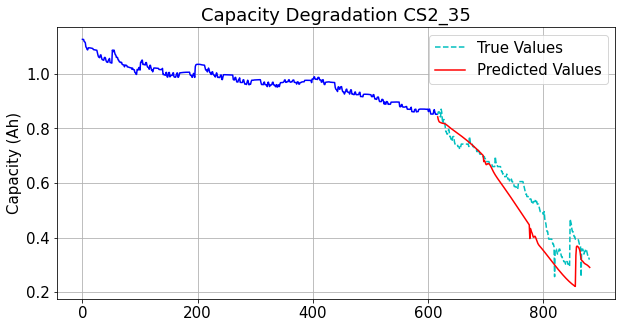

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_35/CS2_35_50.pt"
    #test_path = "tensors/CS2_35/CS2_35_60.pt"
    test_path = "tensors/CS2_35/CS2_35_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_35/scaledinput_CS2_35_50.pt"
    #input_path = "tensors/CS2_35/scaledinput_CS2_35_60.pt"
    input_path = "tensors/CS2_35/scaledinput_CS2_35_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_35/target_CS2_35_50.pt"
    #target_path = "tensors/CS2_35/target_CS2_35_60.pt"
    target_path = "tensors/CS2_35/target_CS2_35_70.pt"
    
    # model paths
    #model_save_path = "models/LSTMCALCE_128_35.pth"
    model_save_path = "models/LSTMCALCE_32_35.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    #hidden_size = 128
    hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[0][1]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_35/input_CS2_35_50.pt"
#input_path = "tensors/CS2_35/input_CS2_35_60.pt"
input_path = "tensors/CS2_35/input_CS2_35_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_35'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

#### hidden_size = 128

Test Split: 50%

MAE: 0.1117 | RMSE: 0.1398 | Accuracy: 77.49
True RUL: 199 | Prediction RUL: 306 | RUL Error: -107
Inference time on cpu: 3.838 seconds
Allocated memory: 5485.8 KiB


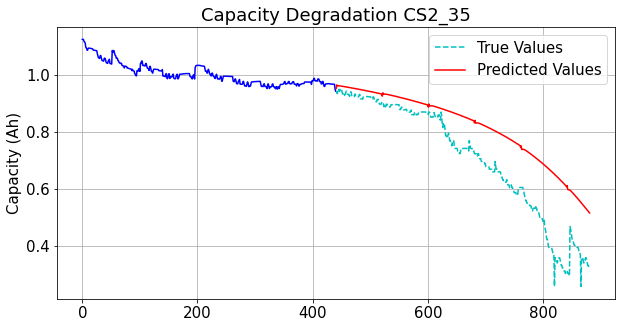

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    test_path = "tensors/CS2_35/CS2_35_50.pt"
    #test_path = "tensors/CS2_35/CS2_35_60.pt"
    #test_path = "tensors/CS2_35/CS2_35_70.pt"

    # scaled input tensor path
    input_path = "tensors/CS2_35/scaledinput_CS2_35_50.pt"
    #input_path = "tensors/CS2_35/scaledinput_CS2_35_60.pt"
    #input_path = "tensors/CS2_35/scaledinput_CS2_35_70.pt"

    # target tensor path
    target_path = "tensors/CS2_35/target_CS2_35_50.pt"
    #target_path = "tensors/CS2_35/target_CS2_35_60.pt"
    #target_path = "tensors/CS2_35/target_CS2_35_70.pt"
    
    # model paths
    model_save_path = "models/LSTMCALCE_128_35.pth"
    #model_save_path = "models/LSTMCALCE_32_35.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    hidden_size = 128
    #hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[0][1]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
input_path = "tensors/CS2_35/input_CS2_35_50.pt"
x_input = torch.load(input_path)
x_input = x_input.tolist()
#input_path = "tensors/CS2_35/scaledinput_CS2_35_60.pt"
#input_path = "tensors/CS2_35/scaledinput_CS2_35_70.pt"
#input_path = "tensors/CS2_35/scaledinput_CS2_35_80.pt"
import matplotlib as mpl
battery_name = 'CS2_35'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 60%

MAE: 0.0366 | RMSE: 0.0491 | Accuracy: 92.40
True RUL: 111 | Prediction RUL: 142 | RUL Error: -31
Inference time on cpu: 1.493 seconds
Allocated memory: 6163.4 KiB


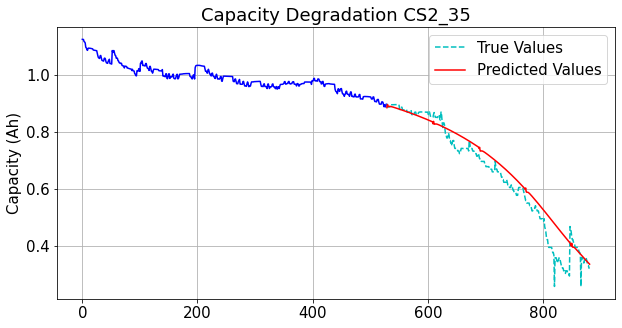

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_35/CS2_35_50.pt"
    test_path = "tensors/CS2_35/CS2_35_60.pt"
    #test_path = "tensors/CS2_35/CS2_35_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_35/scaledinput_CS2_35_50.pt"
    input_path = "tensors/CS2_35/scaledinput_CS2_35_60.pt"
    #input_path = "tensors/CS2_35/scaledinput_CS2_35_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_35/target_CS2_35_50.pt"
    target_path = "tensors/CS2_35/target_CS2_35_60.pt"
    #target_path = "tensors/CS2_35/target_CS2_35_70.pt"
    
    # model paths
    model_save_path = "models/LSTMCALCE_128_35.pth"
    #model_save_path = "models/LSTMCALCE_32_35.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    hidden_size = 128
    #hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[0][1]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_35/input_CS2_35_50.pt"
input_path = "tensors/CS2_35/input_CS2_35_60.pt"
#input_path = "tensors/CS2_35/input_CS2_35_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_35'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 70%

MAE: 0.0899 | RMSE: 0.1012 | Accuracy: 80.95
True RUL: 23 | Prediction RUL: 80 | RUL Error: -57
Inference time on cpu: 1.636 seconds
Allocated memory: 6909.0 KiB


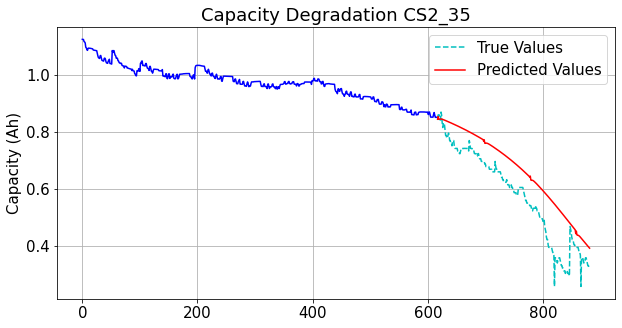

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_35/CS2_35_50.pt"
    #test_path = "tensors/CS2_35/CS2_35_60.pt"
    test_path = "tensors/CS2_35/CS2_35_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_35/scaledinput_CS2_35_50.pt"
    #input_path = "tensors/CS2_35/scaledinput_CS2_35_60.pt"
    input_path = "tensors/CS2_35/scaledinput_CS2_35_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_35/target_CS2_35_50.pt"
    #target_path = "tensors/CS2_35/target_CS2_35_60.pt"
    target_path = "tensors/CS2_35/target_CS2_35_70.pt"
    
    # model paths
    model_save_path = "models/LSTMCALCE_128_35.pth"
    #model_save_path = "models/LSTMCALCE_32_35.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    hidden_size = 128
    #hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[0][1]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_35/input_CS2_35_50.pt"
#input_path = "tensors/CS2_35/input_CS2_35_60.pt"
input_path = "tensors/CS2_35/input_CS2_35_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_35'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

### CS2_38

#### hidden_size = 32

Test Split: 50%

MAE: 0.0177 | RMSE: 0.0242 | Accuracy: 96.99
True RUL: 255 | Prediction RUL: 264 | RUL Error: -9
Inference time on cpu: 0.415 seconds
Allocated memory: 3099.5 KiB


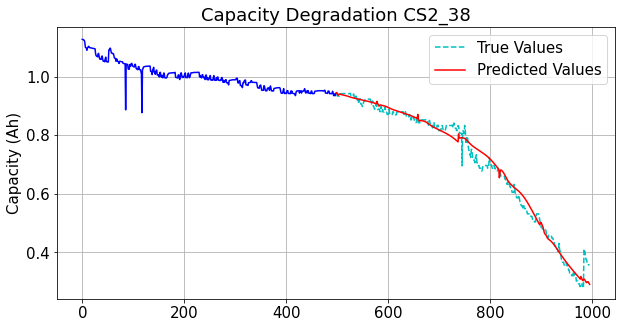

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()

def inference_window(x_input, train_period):
    rem = len(x_input) % train_period
    index = abs(rem - len(x_input))
    num_samples = index // train_period
    x = []
    init_x = -index
    for i in range(num_samples):
        '''
        x.append(x_input[-index-a: a])
        a = a + 100
        index =
        '''
        fin_x = init_x + train_period
        if fin_x == 0:
            x.append(x_input[init_x:])
        else:
            x.append(x_input[init_x:fin_x])
        init_x = fin_x
                      
    return x
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    test_path = "tensors/CS2_38/CS2_38_50.pt"
    #test_path = "tensors/CS2_38/CS2_38_60.pt"
    #test_path = "tensors/CS2_38/CS2_38_70.pt"

    # scaled input tensor path
    input_path = "tensors/CS2_38/scaledinput_CS2_38_50.pt"
    #input_path = "tensors/CS2_38/scaledinput_CS2_38_60.pt"
    #input_path = "tensors/CS2_38/scaledinput_CS2_38_70.pt"

    # target tensor path
    target_path = "tensors/CS2_38/target_CS2_38_50.pt"
    #target_path = "tensors/CS2_38/target_CS2_38_60.pt"
    #target_path = "tensors/CS2_38/target_CS2_38_70.pt"
    
    # model paths
    #model_save_path = "models/LSTMCALCE_128_38.pth"
    model_save_path = "models/LSTMCALCE_32_38.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    #hidden_size = 128
    hidden_size = 32

    #train_period
    train_period = 80
    #prediction_period
    prediction_period = 80

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]
    
    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
input_path = "tensors/CS2_38/input_CS2_38_50.pt"
#input_path = "tensors/CS2_38/input_CS2_38_60.pt"
#input_path = "tensors/CS2_38/input_CS2_38_70.pt"
x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_38'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 60%

MAE: 0.0663 | RMSE: 0.0800 | Accuracy: 86.83
True RUL: 156 | Prediction RUL: 131 | RUL Error: 25
Inference time on cpu: 0.688 seconds
Allocated memory: 6609.9 KiB


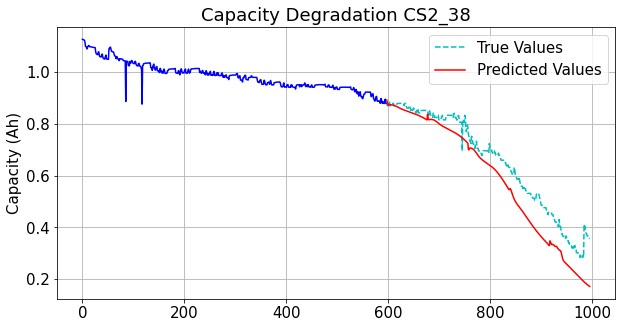

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_38/CS2_38_50.pt"
    test_path = "tensors/CS2_38/CS2_38_60.pt"
    #test_path = "tensors/CS2_38/CS2_38_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_38/scaledinput_CS2_38_50.pt"
    input_path = "tensors/CS2_38/scaledinput_CS2_38_60.pt"
    #input_path = "tensors/CS2_38/scaledinput_CS2_38_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_38/target_CS2_38_50.pt"
    target_path = "tensors/CS2_38/target_CS2_38_60.pt"
    #target_path = "tensors/CS2_38/target_CS2_38_70.pt"
    
    # model paths
    #model_save_path = "models/LSTMCALCE_128_38.pth"
    model_save_path = "models/LSTMCALCE_32_38.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    #hidden_size = 128
    hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_38/input_CS2_38_50.pt"
input_path = "tensors/CS2_38/input_CS2_38_60.pt"
#input_path = "tensors/CS2_38/input_CS2_38_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_38'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 70%

MAE: 0.0216 | RMSE: 0.0297 | Accuracy: 95.87
True RUL: 56 | Prediction RUL: 59 | RUL Error: -3
Inference time on cpu: 0.949 seconds
Allocated memory: 7319.8 KiB


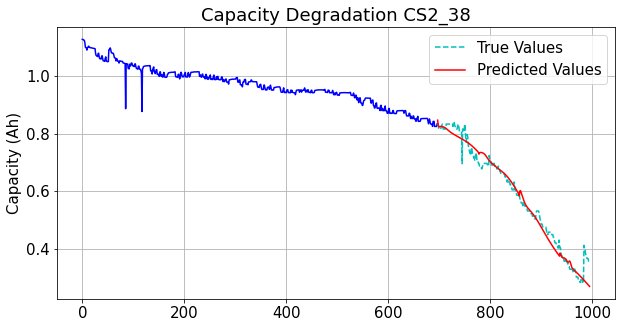

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_38/CS2_38_50.pt"
    #test_path = "tensors/CS2_38/CS2_38_60.pt"
    test_path = "tensors/CS2_38/CS2_38_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_38/scaledinput_CS2_38_50.pt"
    #input_path = "tensors/CS2_38/scaledinput_CS2_38_60.pt"
    input_path = "tensors/CS2_38/scaledinput_CS2_38_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_38/target_CS2_38_50.pt"
    #target_path = "tensors/CS2_38/target_CS2_38_60.pt"
    target_path = "tensors/CS2_38/target_CS2_38_70.pt"
    
    # model paths
    #model_save_path = "models/LSTMCALCE_128_38.pth"
    model_save_path = "models/LSTMCALCE_32_38.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    #hidden_size = 128
    hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_38/input_CS2_38_50.pt"
#input_path = "tensors/CS2_38/input_CS2_38_60.pt"
input_path = "tensors/CS2_38/input_CS2_38_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_38'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

#### hidden_size = 128

Test Split: 50%

MAE: 0.0145 | RMSE: 0.0198 | Accuracy: 97.58
True RUL: 255 | Prediction RUL: 240 | RUL Error: 15
Inference time on cpu: 1.057 seconds
Allocated memory: 7966.5 KiB


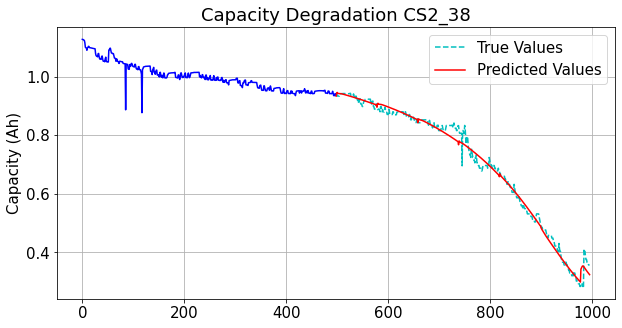

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    test_path = "tensors/CS2_38/CS2_38_50.pt"
    #test_path = "tensors/CS2_38/CS2_38_60.pt"
    #test_path = "tensors/CS2_38/CS2_38_70.pt"

    # scaled input tensor path
    input_path = "tensors/CS2_38/scaledinput_CS2_38_50.pt"
    #input_path = "tensors/CS2_38/scaledinput_CS2_38_60.pt"
    #input_path = "tensors/CS2_38/scaledinput_CS2_38_70.pt"

    # target tensor path
    target_path = "tensors/CS2_38/target_CS2_38_50.pt"
    #target_path = "tensors/CS2_38/target_CS2_38_60.pt"
    #target_path = "tensors/CS2_38/target_CS2_38_70.pt"
    
    # model paths
    model_save_path = "models/LSTMCALCE_128_38.pth"
    #model_save_path = "models/LSTMCALCE_32_38.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    hidden_size = 128
    #hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
input_path = "tensors/CS2_38/input_CS2_38_50.pt"
#input_path = "tensors/CS2_38/input_CS2_38_60.pt"
#input_path = "tensors/CS2_38/input_CS2_38_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_38'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 60%

MAE: 0.0322 | RMSE: 0.0404 | Accuracy: 94.28
True RUL: 156 | Prediction RUL: 131 | RUL Error: 25
Inference time on cpu: 1.362 seconds
Allocated memory: 6098.1 KiB


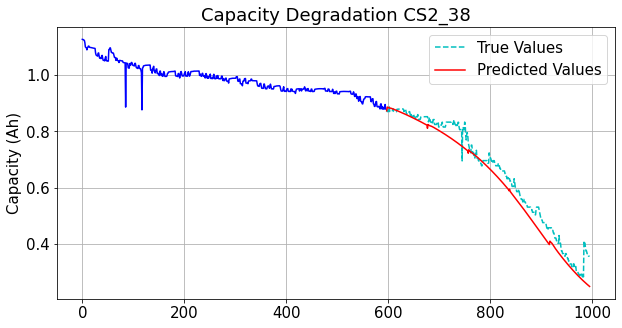

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_38/CS2_38_50.pt"
    test_path = "tensors/CS2_38/CS2_38_60.pt"
    #test_path = "tensors/CS2_38/CS2_38_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_38/scaledinput_CS2_38_50.pt"
    input_path = "tensors/CS2_38/scaledinput_CS2_38_60.pt"
    #input_path = "tensors/CS2_38/scaledinput_CS2_38_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_38/target_CS2_38_50.pt"
    target_path = "tensors/CS2_38/target_CS2_38_60.pt"
    #target_path = "tensors/CS2_38/target_CS2_38_70.pt"
    
    # model paths
    model_save_path = "models/LSTMCALCE_128_38.pth"
    #model_save_path = "models/LSTMCALCE_32_38.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    hidden_size = 128
    #hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_38/input_CS2_38_50.pt"
input_path = "tensors/CS2_38/input_CS2_38_60.pt"
#input_path = "tensors/CS2_38/input_CS2_38_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_38'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 70%

MAE: 0.0214 | RMSE: 0.0281 | Accuracy: 95.71
True RUL: 56 | Prediction RUL: 53 | RUL Error: 3
Inference time on cpu: 1.385 seconds
Allocated memory: 6777.4 KiB


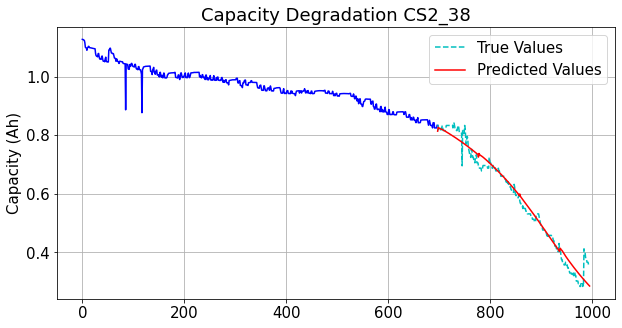

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_38/CS2_38_50.pt"
    #test_path = "tensors/CS2_38/CS2_38_60.pt"
    test_path = "tensors/CS2_38/CS2_38_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_38/scaledinput_CS2_38_50.pt"
    #input_path = "tensors/CS2_38/scaledinput_CS2_38_60.pt"
    input_path = "tensors/CS2_38/scaledinput_CS2_38_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_38/target_CS2_38_50.pt"
    #target_path = "tensors/CS2_38/target_CS2_38_60.pt"
    target_path = "tensors/CS2_38/target_CS2_38_70.pt"
    
    # model paths
    model_save_path = "models/LSTMCALCE_128_38.pth"
    #model_save_path = "models/LSTMCALCE_32_38.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    hidden_size = 128
    #hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_38/input_CS2_38_50.pt"
#input_path = "tensors/CS2_38/input_CS2_38_60.pt"
input_path = "tensors/CS2_38/input_CS2_38_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_38'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

### CS2_37

#### hidden_size = 32

Test Split: 50%

MAE: 0.0240 | RMSE: 0.0303 | Accuracy: 95.29
True RUL: 230 | Prediction RUL: 252 | RUL Error: -22
Inference time on cpu: 0.391 seconds
Allocated memory: 4067.7 KiB


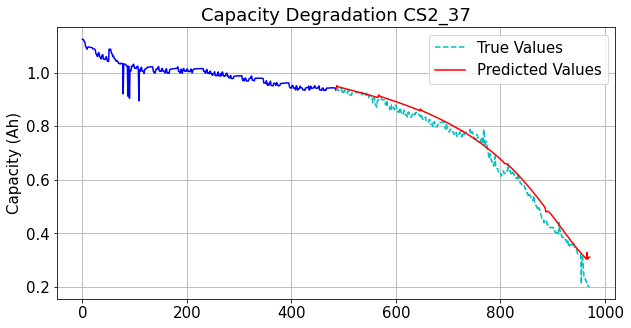

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()

def inference_window(x_input, train_period):
    rem = len(x_input) % train_period
    index = abs(rem - len(x_input))
    num_samples = index // train_period
    x = []
    init_x = -index
    for i in range(num_samples):
        '''
        x.append(x_input[-index-a: a])
        a = a + 100
        index =
        '''
        fin_x = init_x + train_period
        if fin_x == 0:
            x.append(x_input[init_x:])
        else:
            x.append(x_input[init_x:fin_x])
        init_x = fin_x
                      
    return x
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    test_path = "tensors/CS2_37/CS2_37_50.pt"
    #test_path = "tensors/CS2_37/CS2_37_60.pt"
    #test_path = "tensors/CS2_37/CS2_37_70.pt"

    # scaled input tensor path
    input_path = "tensors/CS2_37/scaledinput_CS2_37_50.pt"
    #input_path = "tensors/CS2_37/scaledinput_CS2_37_60.pt"
    #input_path = "tensors/CS2_37/scaledinput_CS2_37_70.pt"

    # target tensor path
    target_path = "tensors/CS2_37/target_CS2_37_50.pt"
    #target_path = "tensors/CS2_37/target_CS2_37_60.pt"
    #target_path = "tensors/CS2_37/target_CS2_37_70.pt"
    
    # model paths
    #model_save_path = "models/LSTMCALCE_128_37.pth"
    model_save_path = "models/LSTMCALCE_32_37.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    #hidden_size = 128
    hidden_size = 32

    #train_period
    train_period = 80
    #prediction_period
    prediction_period = 80

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
input_path = "tensors/CS2_37/input_CS2_37_50.pt"
#input_path = "tensors/CS2_37/input_CS2_37_60.pt"
#input_path = "tensors/CS2_37/input_CS2_37_70.pt"
x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_37'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 60%

MAE: 0.0174 | RMSE: 0.0226 | Accuracy: 96.55
True RUL: 133 | Prediction RUL: 138 | RUL Error: -5
Inference time on cpu: 1.882 seconds
Allocated memory: 8371.2 KiB


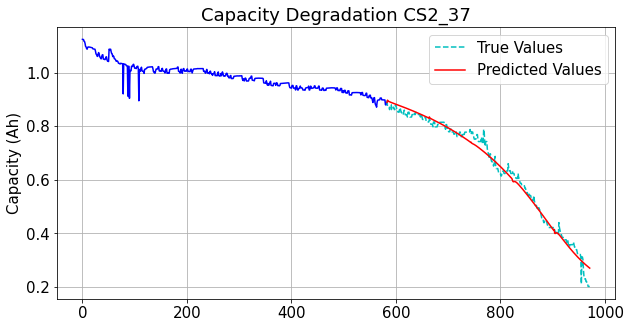

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_37/CS2_37_50.pt"
    test_path = "tensors/CS2_37/CS2_37_60.pt"
    #test_path = "tensors/CS2_37/CS2_37_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_37/scaledinput_CS2_37_50.pt"
    input_path = "tensors/CS2_37/scaledinput_CS2_37_60.pt"
    #input_path = "tensors/CS2_37/scaledinput_CS2_37_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_37/target_CS2_37_50.pt"
    target_path = "tensors/CS2_37/target_CS2_37_60.pt"
    #target_path = "tensors/CS2_37/target_CS2_37_70.pt"
    
    # model paths
    #model_save_path = "models/LSTMCALCE_128_37.pth"
    model_save_path = "models/LSTMCALCE_32_37.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    #hidden_size = 128
    hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_37/input_CS2_37_50.pt"
input_path = "tensors/CS2_37/input_CS2_37_60.pt"
#input_path = "tensors/CS2_37/input_CS2_37_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_37'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 70%

MAE: 0.0416 | RMSE: 0.0459 | Accuracy: 91.72
True RUL: 36 | Prediction RUL: 24 | RUL Error: 12
Inference time on cpu: 1.203 seconds
Allocated memory: 6382.8 KiB


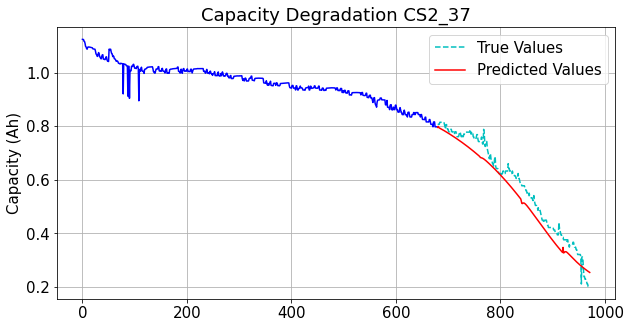

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_37/CS2_37_50.pt"
    #test_path = "tensors/CS2_37/CS2_37_60.pt"
    test_path = "tensors/CS2_37/CS2_37_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_37/scaledinput_CS2_37_50.pt"
    #input_path = "tensors/CS2_37/scaledinput_CS2_37_60.pt"
    input_path = "tensors/CS2_37/scaledinput_CS2_37_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_37/target_CS2_37_50.pt"
    #target_path = "tensors/CS2_37/target_CS2_37_60.pt"
    target_path = "tensors/CS2_37/target_CS2_37_70.pt"
    
    # model paths
    #model_save_path = "models/LSTMCALCE_128_37.pth"
    model_save_path = "models/LSTMCALCE_32_37.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    #hidden_size = 128
    hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_37/input_CS2_37_50.pt"
#input_path = "tensors/CS2_37/input_CS2_37_60.pt"
input_path = "tensors/CS2_37/input_CS2_37_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_37'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

#### hidden_size = 128

Test Split: 50%

MAE: 0.0279 | RMSE: 0.0349 | Accuracy: 94.45
True RUL: 230 | Prediction RUL: 256 | RUL Error: -26
Inference time on cpu: 0.989 seconds
Allocated memory: 7092.1 KiB


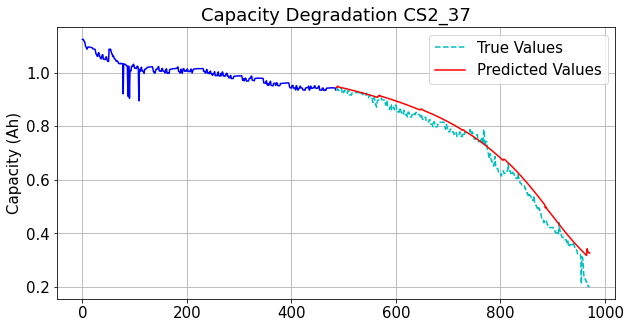

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    test_path = "tensors/CS2_37/CS2_37_50.pt"
    #test_path = "tensors/CS2_37/CS2_37_60.pt"
    #test_path = "tensors/CS2_37/CS2_37_70.pt"

    # scaled input tensor path
    input_path = "tensors/CS2_37/scaledinput_CS2_37_50.pt"
    #input_path = "tensors/CS2_37/scaledinput_CS2_37_60.pt"
    #input_path = "tensors/CS2_37/scaledinput_CS2_37_70.pt"

    # target tensor path
    target_path = "tensors/CS2_37/target_CS2_37_50.pt"
    #target_path = "tensors/CS2_37/target_CS2_37_60.pt"
    #target_path = "tensors/CS2_37/target_CS2_37_70.pt"
    
    # model paths
    model_save_path = "models/LSTMCALCE_128_37.pth"
    #model_save_path = "models/LSTMCALCE_32_37.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    hidden_size = 128
    #hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
input_path = "tensors/CS2_37/input_CS2_37_50.pt"
#input_path = "tensors/CS2_37/input_CS2_37_60.pt"
#input_path = "tensors/CS2_37/input_CS2_37_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_37'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 60%

MAE: 0.0198 | RMSE: 0.0250 | Accuracy: 96.10
True RUL: 133 | Prediction RUL: 136 | RUL Error: -3
Inference time on cpu: 1.588 seconds
Allocated memory: 7842.7 KiB


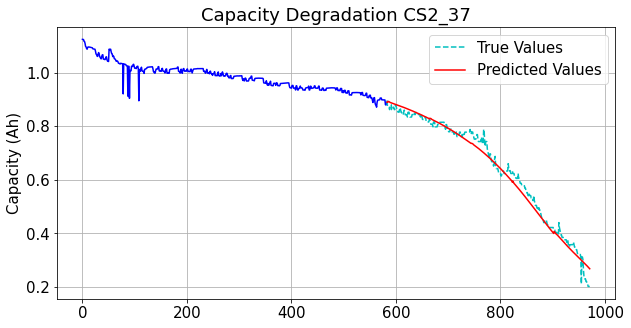

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_37/CS2_37_50.pt"
    test_path = "tensors/CS2_37/CS2_37_60.pt"
    #test_path = "tensors/CS2_37/CS2_37_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_37/scaledinput_CS2_37_50.pt"
    input_path = "tensors/CS2_37/scaledinput_CS2_37_60.pt"
    #input_path = "tensors/CS2_37/scaledinput_CS2_37_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_37/target_CS2_37_50.pt"
    target_path = "tensors/CS2_37/target_CS2_37_60.pt"
    #target_path = "tensors/CS2_37/target_CS2_37_70.pt"
    
    # model paths
    model_save_path = "models/LSTMCALCE_128_37.pth"
    #model_save_path = "models/LSTMCALCE_32_37.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    hidden_size = 128
    #hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_37/input_CS2_37_50.pt"
input_path = "tensors/CS2_37/input_CS2_37_60.pt"
#input_path = "tensors/CS2_37/input_CS2_37_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_37'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 70%

MAE: 0.0442 | RMSE: 0.0488 | Accuracy: 91.33
True RUL: 36 | Prediction RUL: 24 | RUL Error: 12
Inference time on cpu: 1.123 seconds
Allocated memory: 8541.2 KiB


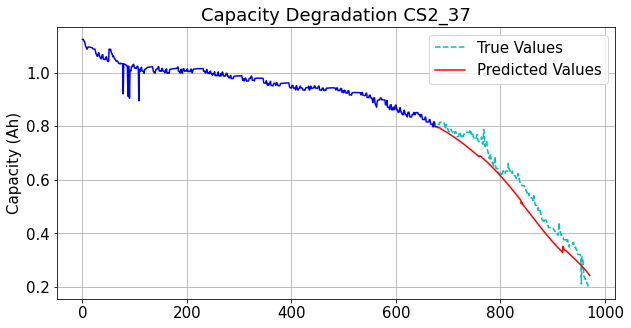

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_37/CS2_37_50.pt"
    #test_path = "tensors/CS2_37/CS2_37_60.pt"
    test_path = "tensors/CS2_37/CS2_37_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_37/scaledinput_CS2_37_50.pt"
    #input_path = "tensors/CS2_37/scaledinput_CS2_37_60.pt"
    input_path = "tensors/CS2_37/scaledinput_CS2_37_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_37/target_CS2_37_50.pt"
    #target_path = "tensors/CS2_37/target_CS2_37_60.pt"
    target_path = "tensors/CS2_37/target_CS2_37_70.pt"
    
    # model paths
    model_save_path = "models/LSTMCALCE_128_37.pth"
    #model_save_path = "models/LSTMCALCE_32_37.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    hidden_size = 128
    #hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_37/input_CS2_37_50.pt"
#input_path = "tensors/CS2_37/input_CS2_37_60.pt"
input_path = "tensors/CS2_37/input_CS2_37_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_37'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

### CS2_36

#### hidden_size = 32

Test Split: 50%

MAE: 0.1828 | RMSE: 0.2200 | Accuracy: 50.08
True RUL: 177 | Prediction RUL: 315 | RUL Error: -138
Inference time on cpu: 0.405 seconds
Allocated memory: 4109.8 KiB


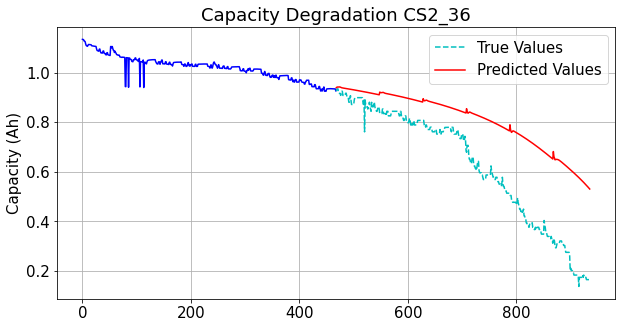

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()

def inference_window(x_input, train_period):
    rem = len(x_input) % train_period
    index = abs(rem - len(x_input))
    num_samples = index // train_period
    x = []
    init_x = -index
    for i in range(num_samples):
        '''
        x.append(x_input[-index-a: a])
        a = a + 100
        index =
        '''
        fin_x = init_x + train_period
        if fin_x == 0:
            x.append(x_input[init_x:])
        else:
            x.append(x_input[init_x:fin_x])
        init_x = fin_x
                      
    return x
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    test_path = "tensors/CS2_36/CS2_36_50.pt"
    #test_path = "tensors/CS2_36/CS2_36_60.pt"
    #test_path = "tensors/CS2_36/CS2_36_70.pt"

    # scaled input tensor path
    input_path = "tensors/CS2_36/scaledinput_CS2_36_50.pt"
    #input_path = "tensors/CS2_36/scaledinput_CS2_36_60.pt"
    #input_path = "tensors/CS2_36/scaledinput_CS2_36_70.pt"

    # target tensor path
    target_path = "tensors/CS2_36/target_CS2_36_50.pt"
    #target_path = "tensors/CS2_36/target_CS2_36_60.pt"
    #target_path = "tensors/CS2_36/target_CS2_36_70.pt"
    
    # model paths
    #model_save_path = "models/LSTMCALCE_128_36.pth"
    model_save_path = "models/LSTMCALCE_32_36.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    #hidden_size = 128
    hidden_size = 32

    #train_period
    train_period = 80
    #prediction_period
    prediction_period = 80

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()


    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
input_path = "tensors/CS2_36/input_CS2_36_50.pt"
#input_path = "tensors/CS2_36/input_CS2_36_60.pt"
#input_path = "tensors/CS2_36/input_CS2_36_70.pt"
x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_36'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 60%

MAE: 0.0453 | RMSE: 0.0711 | Accuracy: 83.65
True RUL: 84 | Prediction RUL: 70 | RUL Error: 14
Inference time on cpu: 0.703 seconds
Allocated memory: 7430.4 KiB


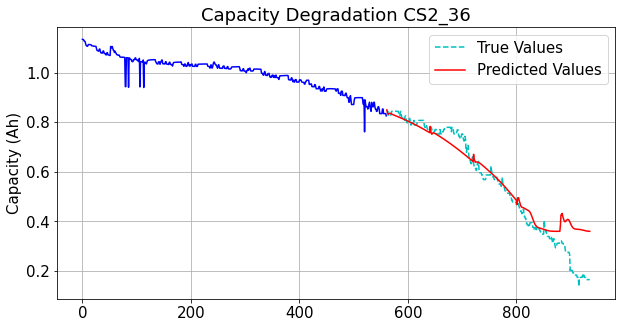

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_36/CS2_36_50.pt"
    test_path = "tensors/CS2_36/CS2_36_60.pt"
    #test_path = "tensors/CS2_36/CS2_36_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_36/scaledinput_CS2_36_50.pt"
    input_path = "tensors/CS2_36/scaledinput_CS2_36_60.pt"
    #input_path = "tensors/CS2_36/scaledinput_CS2_36_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_36/target_CS2_36_50.pt"
    target_path = "tensors/CS2_36/target_CS2_36_60.pt"
    #target_path = "tensors/CS2_36/target_CS2_36_70.pt"
    
    # model paths
    #model_save_path = "models/LSTMCALCE_128_36.pth"
    model_save_path = "models/LSTMCALCE_32_36.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    #hidden_size = 128
    hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_36/input_CS2_36_50.pt"
input_path = "tensors/CS2_36/input_CS2_36_60.pt"
#input_path = "tensors/CS2_36/input_CS2_36_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_36'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 70%

MAE: 0.0662 | RMSE: 0.0887 | Accuracy: 75.70
True RUL: 0 | Prediction RUL: 1 | RUL Error: -1
Inference time on cpu: 0.987 seconds
Allocated memory: 8077.3 KiB


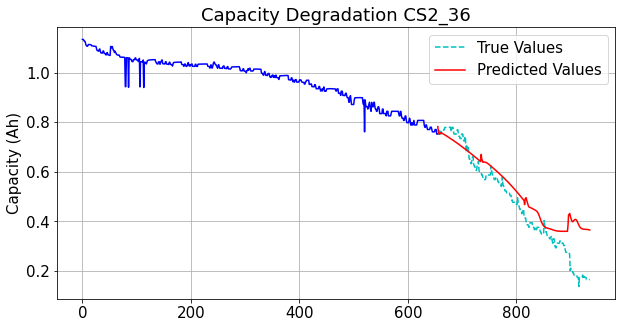

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_36/CS2_36_50.pt"
    #test_path = "tensors/CS2_36/CS2_36_60.pt"
    test_path = "tensors/CS2_36/CS2_36_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_36/scaledinput_CS2_36_50.pt"
    #input_path = "tensors/CS2_36/scaledinput_CS2_36_60.pt"
    input_path = "tensors/CS2_36/scaledinput_CS2_36_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_36/target_CS2_36_50.pt"
    #target_path = "tensors/CS2_36/target_CS2_36_60.pt"
    target_path = "tensors/CS2_36/target_CS2_36_70.pt"
    
    # model paths
    #model_save_path = "models/LSTMCALCE_128_36.pth"
    model_save_path = "models/LSTMCALCE_32_36.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    #hidden_size = 128
    hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_36/input_CS2_36_50.pt"
#input_path = "tensors/CS2_36/input_CS2_36_60.pt"
input_path = "tensors/CS2_36/input_CS2_36_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_36'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

#### hidden_size = 128

Test Split: 50%

MAE: 0.1489 | RMSE: 0.1796 | Accuracy: 59.63
True RUL: 177 | Prediction RUL: 277 | RUL Error: -100
Inference time on cpu: 1.258 seconds
Allocated memory: 8872.9 KiB


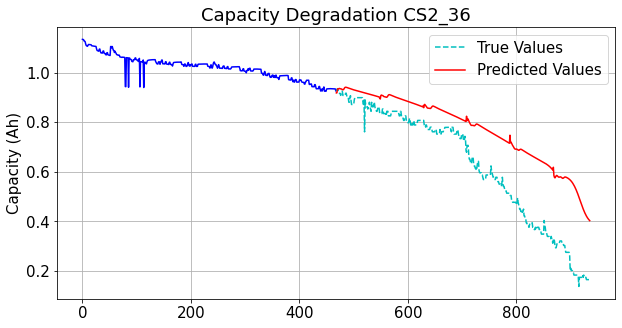

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    test_path = "tensors/CS2_36/CS2_36_50.pt"
    #test_path = "tensors/CS2_36/CS2_36_60.pt"
    #test_path = "tensors/CS2_36/CS2_36_70.pt"

    # scaled input tensor path
    input_path = "tensors/CS2_36/scaledinput_CS2_36_50.pt"
    #input_path = "tensors/CS2_36/scaledinput_CS2_36_60.pt"
    #input_path = "tensors/CS2_36/scaledinput_CS2_36_70.pt"

    # target tensor path
    target_path = "tensors/CS2_36/target_CS2_36_50.pt"
    #target_path = "tensors/CS2_36/target_CS2_36_60.pt"
    #target_path = "tensors/CS2_36/target_CS2_36_70.pt"
    
    # model paths
    model_save_path = "models/LSTMCALCE_128_36.pth"
    #model_save_path = "models/LSTMCALCE_32_36.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    hidden_size = 128
    #hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
input_path = "tensors/CS2_36/input_CS2_36_50.pt"
#input_path = "tensors/CS2_36/input_CS2_36_60.pt"
#input_path = "tensors/CS2_36/input_CS2_36_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_36'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 60%

MAE: 0.0419 | RMSE: 0.0611 | Accuracy: 85.90
True RUL: 84 | Prediction RUL: 69 | RUL Error: 15
Inference time on cpu: 1.081 seconds
Allocated memory: 7590.9 KiB


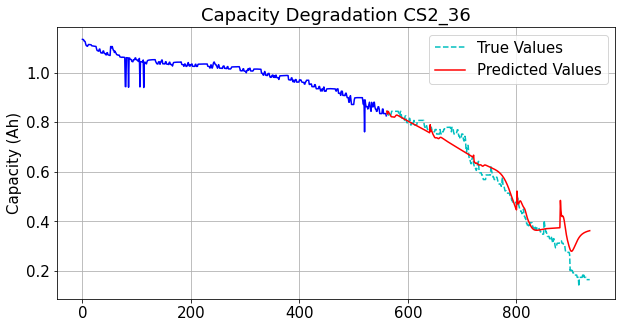

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_36/CS2_36_50.pt"
    test_path = "tensors/CS2_36/CS2_36_60.pt"
    #test_path = "tensors/CS2_36/CS2_36_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_36/scaledinput_CS2_36_50.pt"
    input_path = "tensors/CS2_36/scaledinput_CS2_36_60.pt"
    #input_path = "tensors/CS2_36/scaledinput_CS2_36_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_36/target_CS2_36_50.pt"
    target_path = "tensors/CS2_36/target_CS2_36_60.pt"
    #target_path = "tensors/CS2_36/target_CS2_36_70.pt"
    
    # model paths
    model_save_path = "models/LSTMCALCE_128_36.pth"
    #model_save_path = "models/LSTMCALCE_32_36.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    hidden_size = 128
    #hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_36/input_CS2_36_50.pt"
input_path = "tensors/CS2_36/input_CS2_36_60.pt"
#input_path = "tensors/CS2_36/input_CS2_36_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_36'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

Test Split = 70%

MAE: 0.0630 | RMSE: 0.0772 | Accuracy: 79.15
True RUL: 0 | Prediction RUL: 1 | RUL Error: -1
Inference time on cpu: 0.917 seconds
Allocated memory: 8412.9 KiB


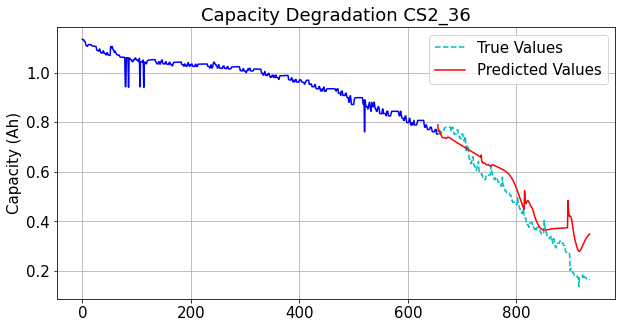

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy
import shutil
import zipfile
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from torch import optim
from math import sqrt
from pickle import load
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from pathlib import Path
from collections import Counter

# Compute for accuracy
def accuracy(y_test: torch.Tensor, y_pred: torch.Tensor):
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
    return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.lstm(flat)
        return out, h

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h):
        out, h = self.lstm(x.unsqueeze(0), h)
        y = self.linear(out.squeeze(0))
        return y, h

class EncoderDecoder(nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size,
                               hidden_size = hidden_size)

        self.decoder = Decoder(input_size = input_size,
                               hidden_size = hidden_size,
                               output_size = output_size)


    def train_model(self, train_battery, train_list, epochs, target_len, method = 'recursive',
                    tfr = 0.5, lr = 0.01, dynamic_tf = False):
        losses = {}
        for name in train_list:
            losses[name] = np.full(epochs+1, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.HuberLoss()
        for e in range(epochs+1):
            for name in train_list:
                train = to_tensor(train_battery[name]['X'])
                target = to_tensor(train_battery[name]['Y'])
                train = train.to(device)
                target = target.to(device)

                predicted = torch.zeros(target_len, train.shape[1], train.shape[2])
                predicted = predicted.to(device)
                optimizer.zero_grad()
                _, enc_h = self.encoder(train)
                dec_in = train[-1, :, :]
                dec_h = enc_h

                '''
                Recursive training is passing each decoder's output to the decoder's
                input at another step, which is as follows:
                '''
                if method == 'recursive':
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

                '''
                Teacher forcing method applies recursive training with probability
                or supplies target values to the encoder with probability tfr:
                '''
                if method == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < tfr:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = target[t, :, :]
                    # predict recursively
                    else:
                        for t in range(target_len):
                            dec_out, dec_h = self.decoder(dec_in, dec_h)
                            predicted[t] = dec_out
                            dec_in = dec_out

                '''
                Mixed teacher forcing method mixes the decoder output with 
                target values within the same training epoch:
                '''
                if method == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        # predict with teacher forcing
                        if random.random() < tfr:
                            dec_in = target[t, :, :]
                        #predict recursively
                        else:
                            dec_in = dec_out
            
                loss = criterion(predicted, target)
                loss.backward()
                optimizer.step()
                losses[name][e] = loss.item()
                if e % 100 == 0:
                    print(f'Battery: {name} |Epoch {e}/{epochs}: {round(loss.item(), 4)}')
            
                # In some cases, it is helpful to decrease the teacher forcing ration during training
                # dynamic teacher forcing
                if dynamic_tf and tfr > 0:
                    tfr = tfr - 0.02
        return losses
    
    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], x.shape[2])
        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, :]
        dec_h = enc_h
        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out
        return y

# transform numpy to tensor
def to_tensor(data):
    return torch.tensor(data).unsqueeze(2).transpose(0,1).float()
    
if __name__ == "__main__":
    Rated_Capacity = 1.1
    start_time = timer()
    tracemalloc.start()
    max_length = 1500
    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # test tensor path
    #test_path = "tensors/CS2_36/CS2_36_50.pt"
    #test_path = "tensors/CS2_36/CS2_36_60.pt"
    test_path = "tensors/CS2_36/CS2_36_70.pt"

    # scaled input tensor path
    #input_path = "tensors/CS2_36/scaledinput_CS2_36_50.pt"
    #input_path = "tensors/CS2_36/scaledinput_CS2_36_60.pt"
    input_path = "tensors/CS2_36/scaledinput_CS2_36_70.pt"

    # target tensor path
    #target_path = "tensors/CS2_36/target_CS2_36_50.pt"
    #target_path = "tensors/CS2_36/target_CS2_36_60.pt"
    target_path = "tensors/CS2_36/target_CS2_36_70.pt"
    
    # model paths
    model_save_path = "models/LSTMCALCE_128_36.pth"
    #model_save_path = "models/LSTMCALCE_32_36.pth"

    scaler = scaler = load(open('scaler.pkl', 'rb'))

    hidden_size = 128
    #hidden_size = 32

    x_in = torch.load(test_path)
    x_input = torch.load(input_path)
    x_input = x_input.tolist()
    x_target = torch.load(target_path)
    x_target = x_target.tolist()

    loadedmodel = EncoderDecoder(hidden_size = hidden_size)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))

    loadedmodel.eval()
    output = []
    while len(x_input) <= max_length:
        predicted = loadedmodel.predict(x_in, prediction_period)
        pred_seq = predicted[:, -1, :].view(-1).tolist()   
        for i in range(len(pred_seq)):
            x_input.append([pred_seq[i]])
            output.append([pred_seq[i]])
        X = inference_window(x_input, train_period)
        X = np.array(X)
        X = np.squeeze(X)
        x_in = to_tensor(X)
    
    output = scaler.inverse_transform(np.array(output).reshape(-1,1))
    output = output.tolist()
    acc = accuracy(torch.Tensor(x_target), torch.Tensor(output[:len(x_target)])) * 100
    mae = mean_absolute_error(output[:len(x_target)], x_target)
    mse = sqrt(mean_squared_error(output[:len(x_target)], x_target))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (torch.Tensor(x_target)<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(x_target[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (torch.Tensor(output[:len(x_target)])<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"MAE: {mae:.4f} | RMSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    end_time = timer()
    snapshot = tracemalloc.take_snapshot()
    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)

#input tensor path
#input_path = "tensors/CS2_36/input_CS2_36_50.pt"
#input_path = "tensors/CS2_36/input_CS2_36_60.pt"
input_path = "tensors/CS2_36/input_CS2_36_70.pt"

x_input = torch.load(input_path)
x_input = x_input.tolist()

import matplotlib as mpl
battery_name = 'CS2_36'
x = range(0, len(x_input) + len(x_target))
font = {'size'   : 15}
mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Capacity Degradation '+battery_name)
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.plot(x[:-len(x_target)],
         x_input,
         "b-")
plt.plot(x[-len(x_target):],
         x_target,
         "c--",
         label='True Values')
plt.plot(x[-len(x_target):],
         output[:len(x_target)],
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)